# Credit Card Dataset for Clustering

- Dados: https://www.kaggle.com/arjunbhasin2013/ccdata



## Importação das bibliotecas e base de dados

In [1]:
!pip install pywaffle
!pip install ydata-profiling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 22.1 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=b2c4d010b629974f64a7c1ce374a873e9cc1db93b588e0401083393ee0735662
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [2]:
import kagglehub
path = kagglehub.dataset_download("arjunbhasin2013/ccdata")

print("Path:", path)

100%|██████████| 340k/340k [00:00<00:00, 64.2MB/s]

Extracting files...
Path: /root/.cache/kagglehub/datasets/arjunbhasin2013/ccdata/versions/1


In [3]:
import os
os.listdir(path)

['CC GENERAL.csv']

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.style import set_palette
from pywaffle import Waffle
from yellowbrick.contrib.wrapper import wrap

from matplotlib.patches import Rectangle
from ydata_profiling import ProfileReport

In [5]:
creditcard_df = pd.read_csv(path+'/CC GENERAL.csv')

In [6]:
creditcard_df.shape

(8950, 18)

# Segmentação de Clientes

Este caso requer o desenvolvimento de uma segmentação de clientes para definir uma estratégia de marketing.  
O conjunto de dados resume o comportamento de uso de 8.950 titulares ativos de cartões de crédito nos últimos 6 meses.  
O arquivo contém informações do cliente com 18 variáveis comportamentais.  

## Dicionário de Dados do Conjunto de Dados de Cartões de Crédito:

- **CUST_ID**: Identificação do titular do cartão de crédito (Categórico).  
- **BALANCE**: Valor do saldo restante na conta para realizar compras.  
- **BALANCE_FREQUENCY**: Frequência com que o saldo é atualizado, pontuação entre 0 e 1 (1 = frequentemente atualizado, 0 = raramente atualizado).  
- **PURCHASES**: Valor das compras realizadas na conta.  
- **ONEOFF_PURCHASES**: Maior valor de compra realizado de uma vez.  
- **INSTALLMENTS_PURCHASES**: Valor das compras realizadas em parcelas.  
- **CASH_ADVANCE**: Valor de adiantamento em dinheiro fornecido ao usuário.  
- **PURCHASES_FREQUENCY**: Frequência com que as compras são realizadas, pontuação entre 0 e 1 (1 = frequentemente realizadas, 0 = raramente realizadas).  
- **ONEOFFPURCHASESFREQUENCY**: Frequência com que as compras de uma vez só são realizadas (1 = frequentemente realizadas, 0 = raramente realizadas).  
- **PURCHASESINSTALLMENTSFREQUENCY**: Frequência com que as compras parceladas são realizadas (1 = frequentemente realizadas, 0 = raramente realizadas).  
- **CASHADVANCEFREQUENCY**: Frequência com que os adiantamentos em dinheiro são realizados.  
- **CASHADVANCETRX**: Número de transações realizadas com adiantamento em dinheiro.  
- **PURCHASES_TRX**: Número de transações de compras realizadas.  
- **CREDIT_LIMIT**: Limite de crédito do cartão para o usuário.  
- **PAYMENTS**: Valor dos pagamentos realizados pelo usuário.  
- **MINIMUM_PAYMENTS**: Valor mínimo de pagamento realizado pelo usuário.  
- **PRCFULLPAYMENT**: Percentual de pagamento total realizado pelo usuário.  
- **TENURE**: Tempo de serviço do cartão de crédito para o usuário.  


In [7]:
# from pandas_profiling import ProfileReport

profile = ProfileReport(
    creditcard_df.drop(columns=['CUST_ID']),
    title="Relatório dos Dados",
    minimal=True,
    progress_bar=False,
    samples=None,
    correlations=None,
    interactions=None,
    explorative=True,
    notebook={"iframe": {"height": "600px"}},
    missing_diagrams={"heatmap": False, "dendrogram": False},
)

profile.to_notebook_iframe()

In [8]:
creditcard_df.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

Verificando se cada registro é um cliente e não repete

In [9]:
len(np.unique(creditcard_df['CUST_ID'])) == creditcard_df.shape[0]

True

In [10]:
creditcard_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

PRC_FULL_PAYMENT = média de apenas 15% pagam a fatura total, ou seja, pode ser que 85% estejam endividados

In [11]:
creditcard_df.describe()

BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.000000             0.000000   
25%                  0.000000      0.000000             0.083333   
50%                 89.000000      0.000000             0.500000   
75%                468.637500   1113.821139             0.916667   
max              22500.000000  47137.211760             1.000000   

       ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
count                 8950.000000                       8950.000000   
mean                     0.202458                          0.364437   
std                      0.298336                          0.397448   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.083333                          0.166667   
75%                      0.300000                          0.750000   
max                      1.000000                          1.000000   

       CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
count             8950.000000       8950.000000    8950.000000   8949.000000   
mean                 0.135144          3.248827      14.709832   4494.449450   
std                  0.200121          6.824647      24.857649   3638.815725   
min                  0.000000          0.000000       0.000000     50.000000   
25%                  0.000000          0.000000       1.000000   1600.000000   
50%                  0.000000          0.000000       7.000000   3000.000000   
75%                  0.222222          4.000000      17.000000   6500.000000   
max                  1.500000        123.000000     358.000000  30000.000000   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT       TENURE  
count   8950.000000       8637.000000       8950.000000  8950.000000  
mean    1733.143852        864.206542          0.153715    11.517318  
std     2895.063757       2372.446607          0.292499     1.338331  
min        0.000000          0.019163          0.000000     6.000000  
25%      383.276166        169.123707          0.000000    12.000000  
50%      856.901546        312.343947          0.000000    12.000000  
75%     1901.134317        825.485459          0.142857    12.000000  
max    50721.483360      76406.207520          1.000000    12.000000

## Análise Exploratória dos Dados (EDA)

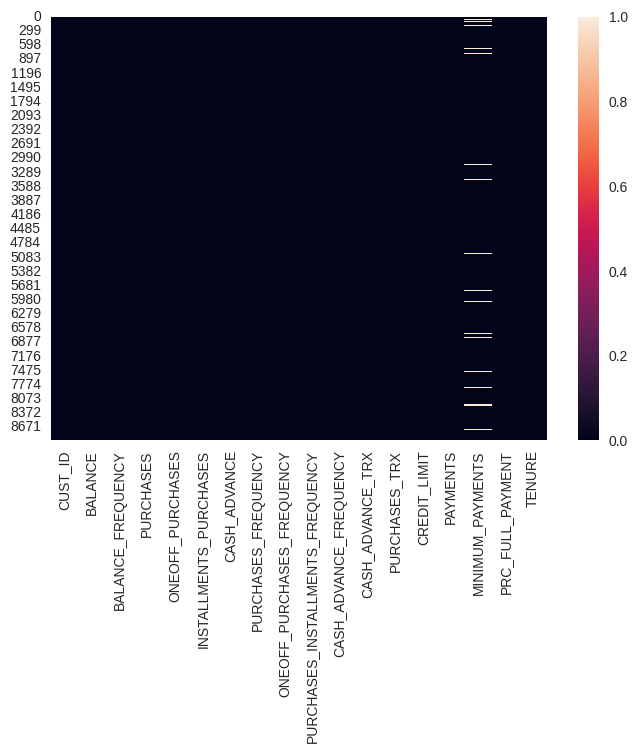

In [12]:
sns.heatmap(creditcard_df.isnull());

In [13]:
creditcard_df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [14]:
creditcard_df.describe()

BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.000000             0.000000   
25%                  0.000000      0.000000             0.083333   
50%                 89.000000      0.000000             0.500000   
75%                468.637500   1113.821139             0.916667   
max              22500.000000  47137.211760             1.000000   

       ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
count                 8950.000000                       8950.000000   
mean                     0.202458                          0.364437   
std                      0.298336                          0.397448   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.083333                          0.166667   
75%                      0.300000                          0.750000   
max                      1.000000                          1.000000   

       CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
count             8950.000000       8950.000000    8950.000000   8949.000000   
mean                 0.135144          3.248827      14.709832   4494.449450   
std                  0.200121          6.824647      24.857649   3638.815725   
min                  0.000000          0.000000       0.000000     50.000000   
25%                  0.000000          0.000000       1.000000   1600.000000   
50%                  0.000000          0.000000       7.000000   3000.000000   
75%                  0.222222          4.000000      17.000000   6500.000000   
max                  1.500000        123.000000     358.000000  30000.000000   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT       TENURE  
count   8950.000000       8637.000000       8950.000000  8950.000000  
mean    1733.143852        864.206542          0.153715    11.517318  
std     2895.063757       2372.446607          0.292499     1.338331  
min        0.000000          0.019163          0.000000     6.000000  
25%      383.276166        169.123707          0.000000    12.000000  
50%      856.901546        312.343947          0.000000    12.000000  
75%     1901.134317        825.485459          0.142857    12.000000  
max    50721.483360      76406.207520          1.000000    12.000000

quando tiver valor nulo no limite de crétido, troca pela média de toda a coluna do cartão de crétido

In [15]:
creditcard_df.loc[(creditcard_df['CREDIT_LIMIT'].isnull() == True), 'CREDIT_LIMIT'] = creditcard_df['CREDIT_LIMIT'].mean()

In [16]:
creditcard_df.loc[(creditcard_df['MINIMUM_PAYMENTS'].isnull() == True), 'MINIMUM_PAYMENTS'] = creditcard_df['MINIMUM_PAYMENTS'].mean()

In [17]:
creditcard_df.isnull().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

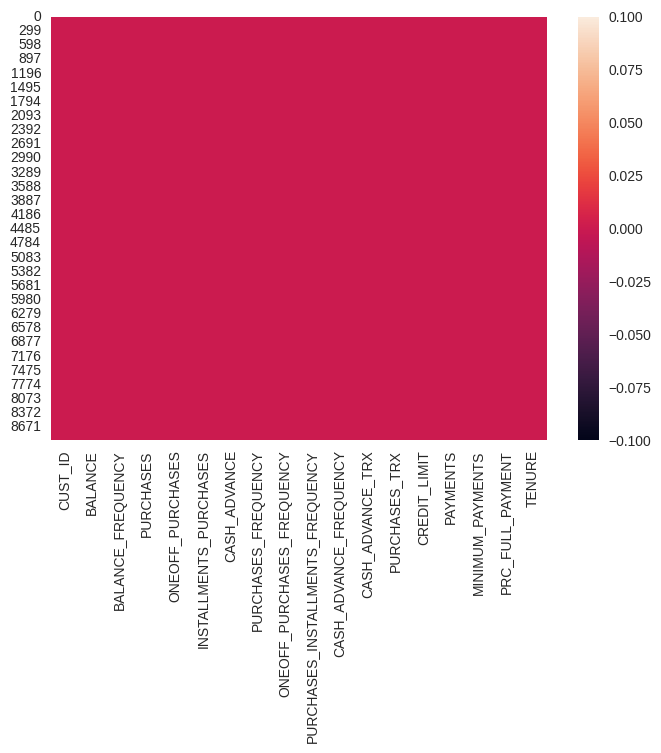

In [18]:
sns.heatmap(creditcard_df.isnull());

In [19]:
creditcard_df.duplicated().sum()

0

In [20]:
#remove o id do cliente, pois não será necessário
# creditcard_df.drop('CUST_ID', axis = 1, inplace = True)

In [21]:
creditcard_df.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000        864.206542          0.000000      12  
4   678.334763        244.791237          0.000000      12

In [22]:
creditcard_df.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

In [23]:
len(creditcard_df.columns)

18

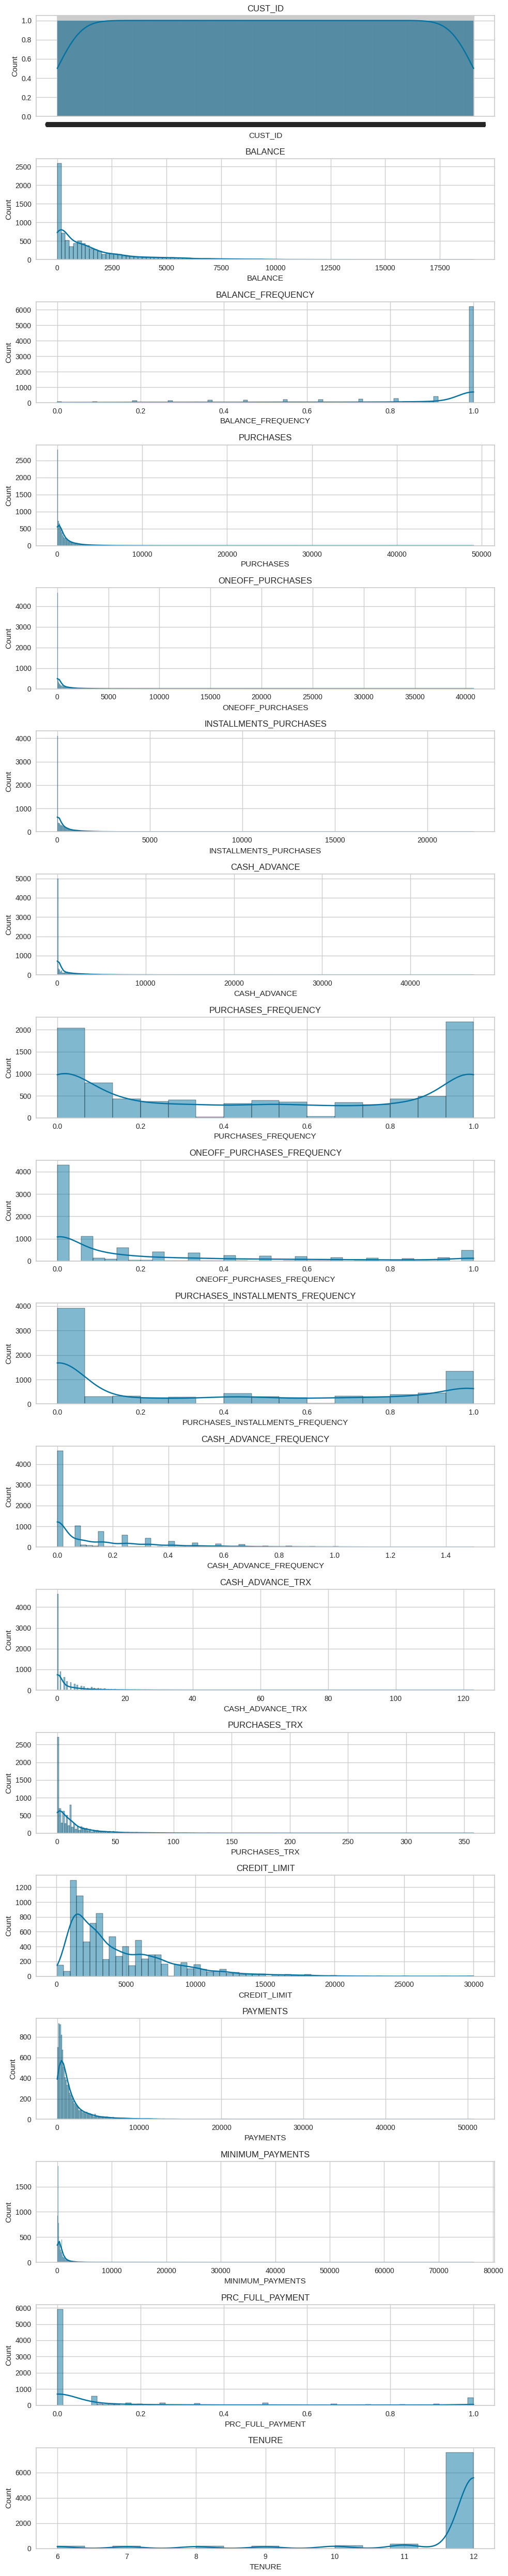

In [24]:
num_columns = len(creditcard_df.columns)
plt.figure(figsize=(10, 50))

for i, column in enumerate(creditcard_df.columns, start=1):
    plt.subplot(num_columns, 1, i)
    sns.histplot(creditcard_df[column], kde=True)
    plt.title(column)

plt.tight_layout()
plt.show()

In [25]:
correlations = creditcard_df.drop(columns=['CUST_ID']).corr()

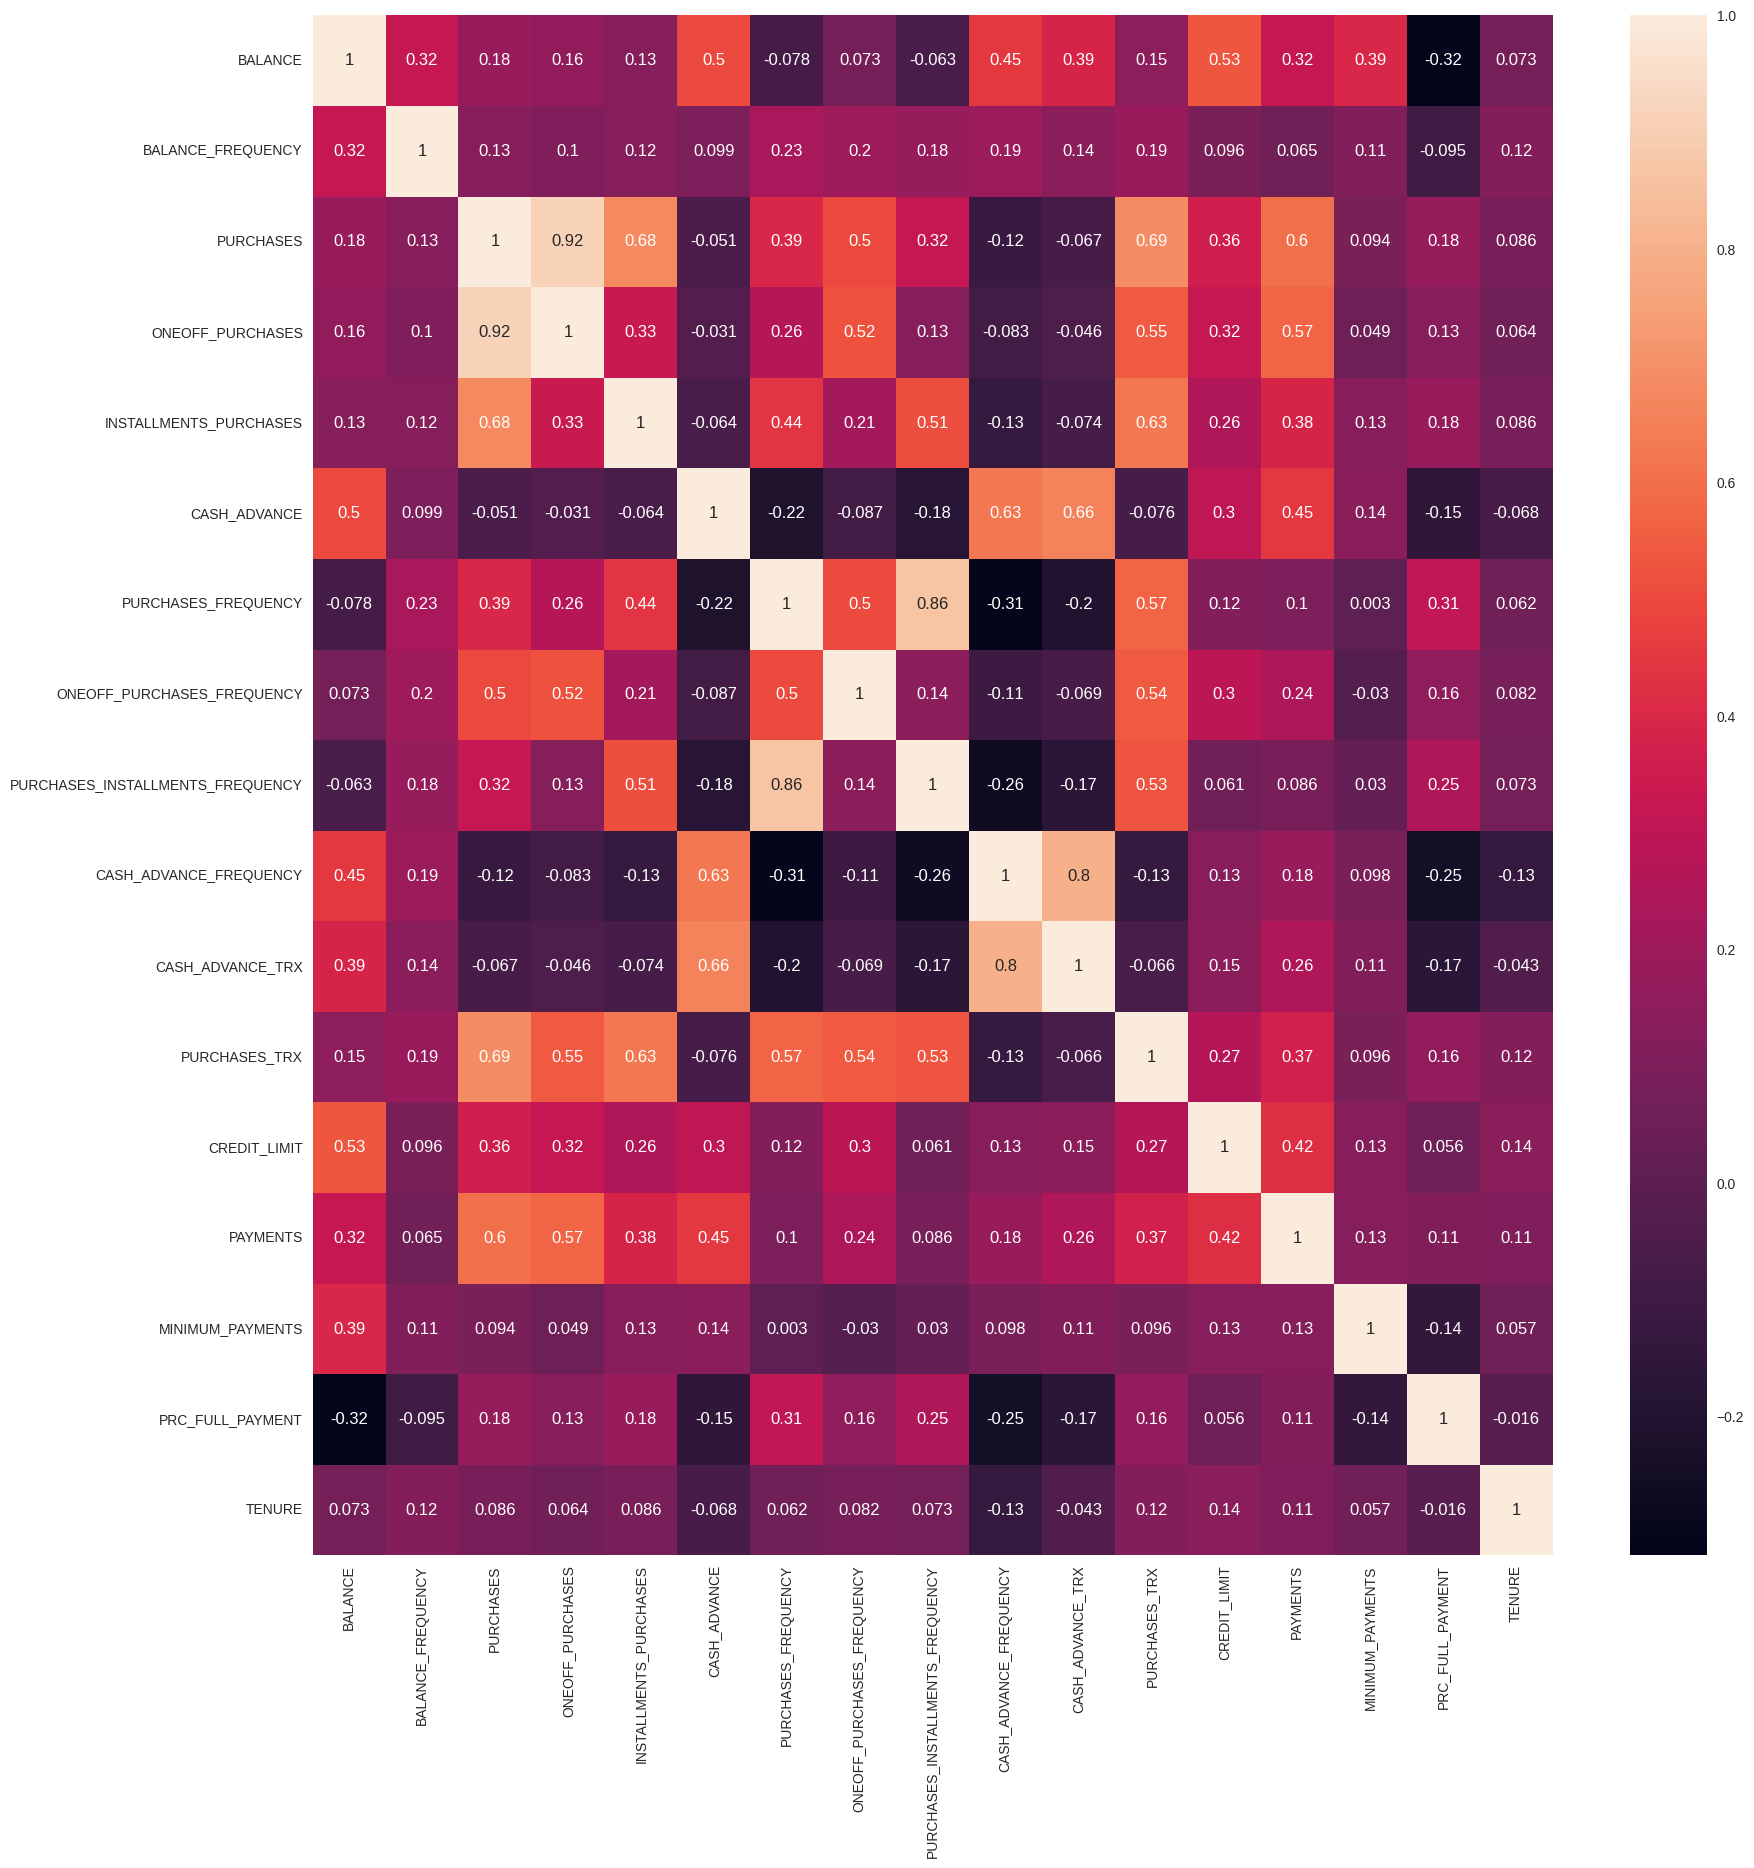

In [26]:
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(correlations, annot=True);
# maior parte das compras, estão relacionados com a compra à vista
# os maiores valores de compra estão relacionados a compra à vista
# limite de cartão de crédito não uma relação forte no valor total de compra que os clientes do banco fazem

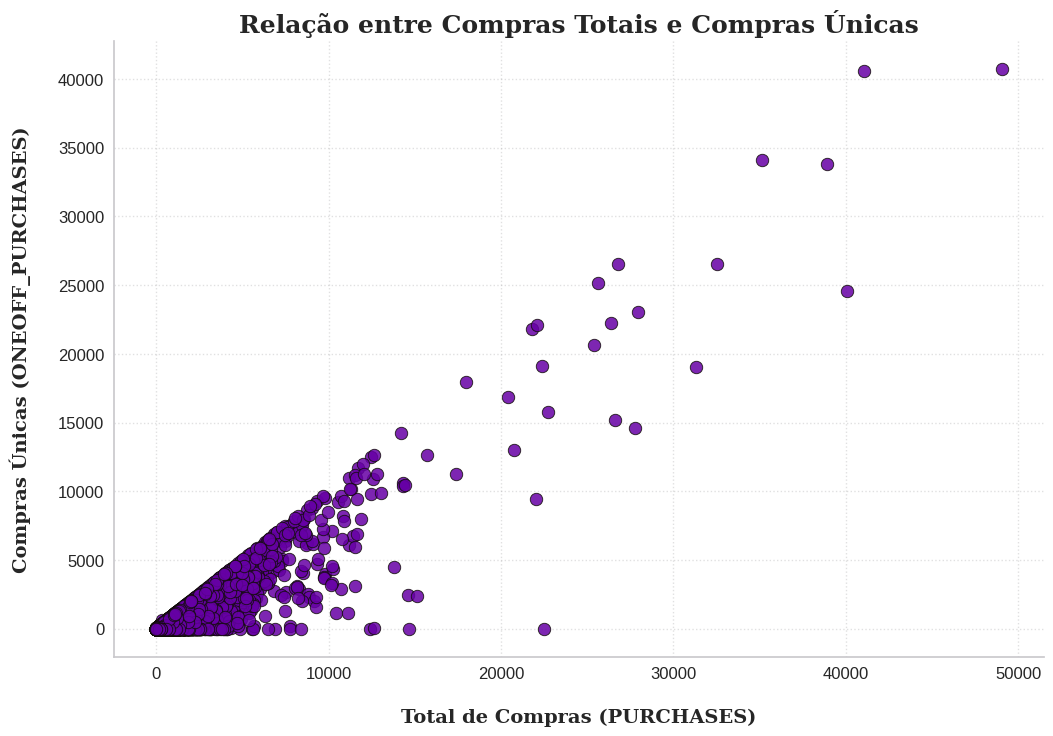

In [27]:
plt.figure(figsize=(12, 8))

scatter_style = dict(linewidth=0.65, edgecolor='#100C07', alpha=0.85)
grid_style = dict(alpha=0.3, color='#9B9A9C', linestyle='dotted', zorder=1)
xy_label = dict(fontweight='bold', fontsize=14, fontfamily='serif')
title_style = dict(fontsize=18, fontweight='heavy', fontfamily='serif')

# Gráfico de Dispersão (scatter plot)
plt.scatter(
    creditcard_df['PURCHASES'],
    creditcard_df['ONEOFF_PURCHASES'],
    s=80, color='#6600A5', **scatter_style
)
plt.title(
    "Relação entre Compras Totais e Compras Únicas",
    loc='center', **title_style
)
plt.xlabel("\nTotal de Compras (PURCHASES)", **xy_label)
plt.ylabel("Compras Únicas (ONEOFF_PURCHASES)\n", **xy_label)

plt.grid(axis='y', which='major', **grid_style)
plt.grid(axis='x', which='major', **grid_style)
for spine in plt.gca().spines.values():
    spine.set_color('None')
for spine in ['bottom', 'left']:
    plt.gca().spines[spine].set_visible(True)
    plt.gca().spines[spine].set_color('#CAC9CD')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


No gráfico acima, obserba-se o comportamento de compra consistente:

- Clientes que gastam mais no total (alto valor em PURCHASES) geralmente também gastam mais em compras únicas (ONEOFF_PURCHASES), sugerindo que essas compras representam uma grande parte do consumo.

- Se a empresa quiser aumentar o valor total de compras dos clientes, pode ser interessante criar promoções ou incentivos focados em compras únicas, já que elas parecem ser um fator determinante.

<ipython-input-28-e924143e9901>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda1['TENURE'] = eda1['TENURE'].astype(str)


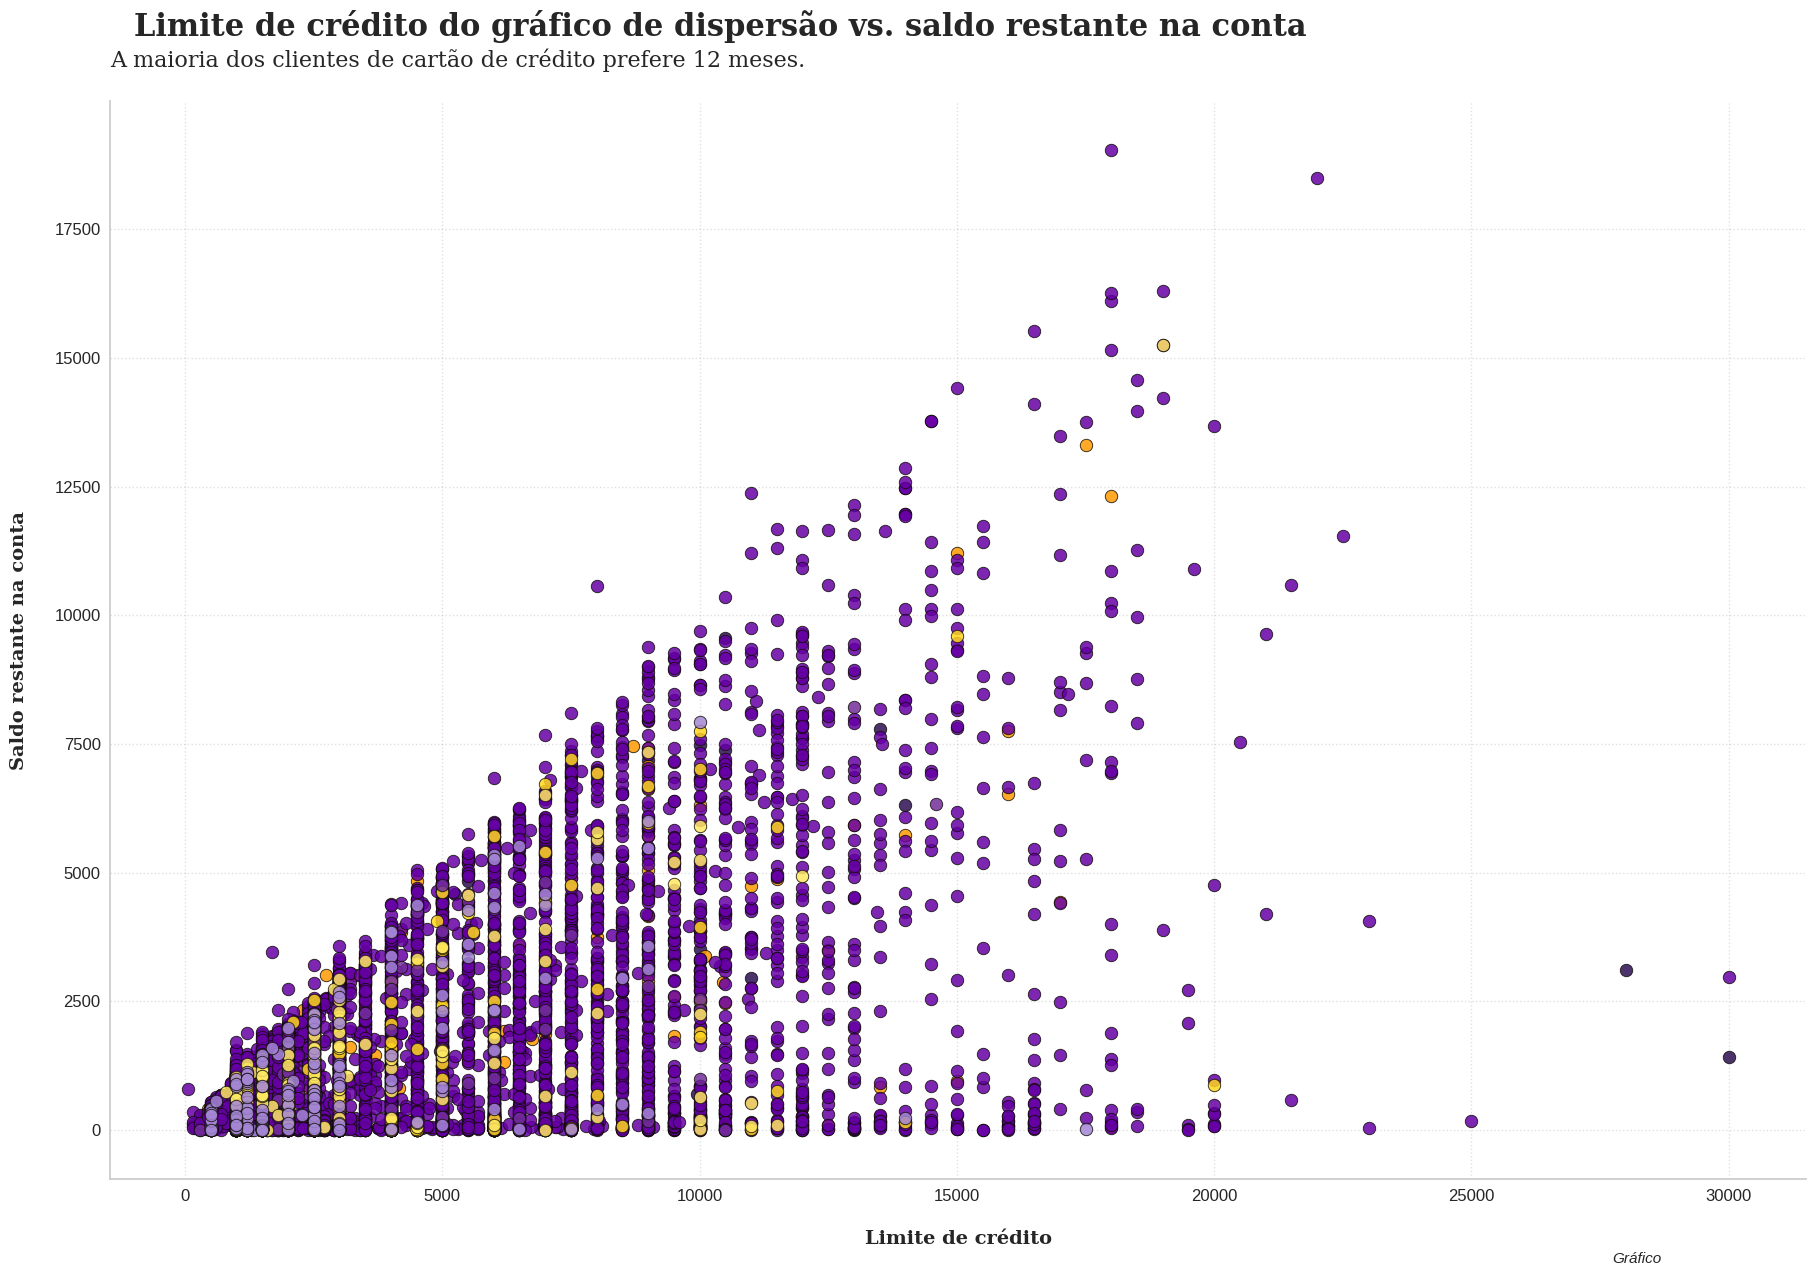

In [28]:
scatter_style=dict(linewidth=0.65, edgecolor='#100C07', alpha=0.85)
sub_scatter_style_color=dict(s=5, alpha=0.65, linewidth=0.15, zorder=10, edgecolor='#100C07')
sub_scatter_style_grey=dict(s=5, alpha=0.3, linewidth=0.7, zorder=5, color='#CAC9CD')
grid_style=dict(alpha=0.3, color='#9B9A9C', linestyle='dotted', zorder=1)
xy_label=dict(fontweight='bold', fontsize=14, fontfamily='serif')
suptitle=dict(fontsize=22, fontweight='heavy', fontfamily='serif')
title=dict(fontsize=16, fontfamily='serif')
color_pallete=['#2D0F51', '#FF9A00', '#6600A5', '#FFD61E', '#722E9A', '#FFE863', '#A486D5']
sub_axes=[None] * 7

eda1 = creditcard_df[['CREDIT_LIMIT', 'BALANCE', 'TENURE']]
eda1['TENURE'] = eda1['TENURE'].astype(str)
tenure = sorted(eda1['TENURE'].unique())

fig = plt.figure(figsize=(22, 14))
gs = fig.add_gridspec(7, 7)
ax = fig.add_subplot(gs[:, :7])
ax.set_aspect(1)

for x in range(len(tenure)):
    eda1_x = eda1[eda1['TENURE']==tenure[x]]
    ax.scatter(eda1_x['CREDIT_LIMIT'], eda1_x['BALANCE'], s=80, color=color_pallete[x], **scatter_style)
    ax.set_title('A maioria dos clientes de cartão de crédito prefere 12 meses.\n', loc='left', **title)
    ax.set_xlabel('\nLimite de crédito', **xy_label)
    ax.set_ylabel('Saldo restante na conta\n', **xy_label)
    ax.grid(axis='y', which='major', **grid_style)
    ax.grid(axis='x', which='major', **grid_style)
    for spine in ax.spines.values():
        spine.set_color('None')
    for spine in ['bottom', 'left']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('#CAC9CD')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

plt.suptitle('Limite de crédito do gráfico de dispersão vs. saldo restante na conta', x=0.138, y=0.945, ha='left', **suptitle)
plt.gcf().text(0.81, 0.05, 'Gráfico', style='italic', fontsize=11)
plt.show()


No gráfico acima, observa-se:

- Clientes com um limite de crédito mais alto tendem a ter um saldo restante maior na conta.
- Isso pode indicar que clientes com maior crédito disponível utilizam menos do seu limite ou mantêm mais recursos disponíveis.

**Heterocedasticidade**

- Baixo TENURE: Clientes novos têm uma relação mais previsível entre saldo e limite (menor variância). Possivelmente estão em faixas mais homogêneas de crédito inicial.
- Alto TENURE: Clientes antigos apresentam maior dispersão, com diferentes perfis de uso e limites. Isso reflete maior personalização por parte da instituição financeira.

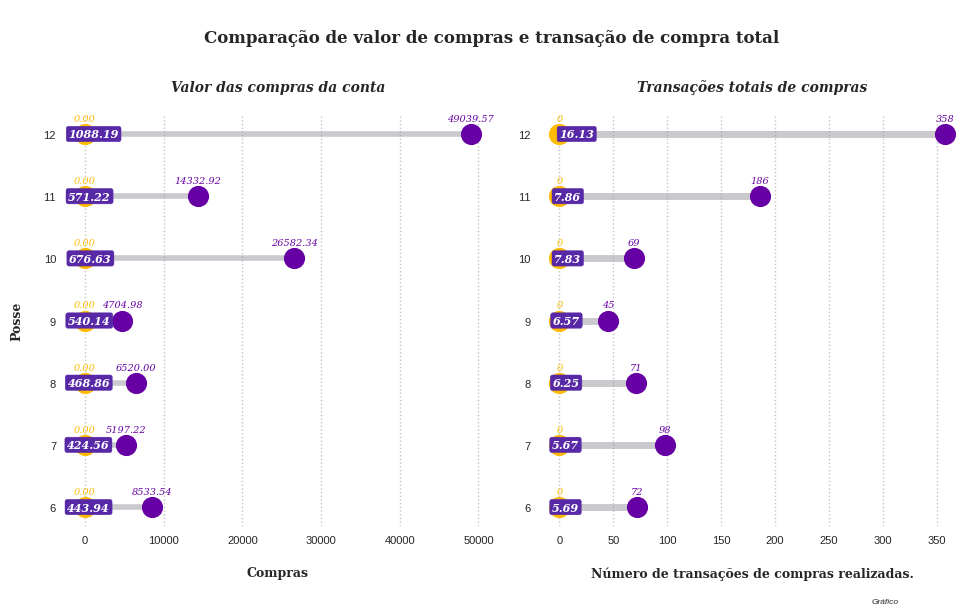

In [29]:
title=dict(fontsize=10, fontfamily='serif', style='italic', weight='bold', ha='center')
grid_style = dict(alpha=0.6, color='#9B9A9C', linestyle='dotted', zorder=1)
sct_style = dict(s=175, linewidth=2)
xy_label = dict(fontweight='bold', fontsize=9, fontfamily='serif')
ann_style = dict(xytext=(0, 0), textcoords='offset points', va='center', ha='center', style='italic', fontfamily='serif')
tenure = sorted(creditcard_df['TENURE'].unique())
color_pallete = ['#2D0F51', '#FF9A00', '#6600A5', '#FFD61E', '#722E9A', '#FFE863', '#A486D5']

eda2_1 = creditcard_df[['PURCHASES', 'TENURE']]
eda2_1 = eda2_1.groupby('TENURE').agg(MIN=('PURCHASES', 'min'), AVG=('PURCHASES', 'mean'), MAX=('PURCHASES', 'max')).reset_index()

eda2_2 = creditcard_df[['PURCHASES_TRX', 'TENURE']]
eda2_2 = eda2_2.groupby('TENURE').agg(MIN=('PURCHASES_TRX', 'min'), AVG=('PURCHASES_TRX', 'mean'), MAX=('PURCHASES_TRX', 'max')).reset_index()

fig = plt.figure(figsize=(10, 6))
plt.suptitle('\nComparação de valor de compras e transação de compra total', fontweight='heavy', fontsize=12, fontfamily='serif')

plt.subplot(1, 2, 1)
plt.tight_layout(rect=[0, 0, 1, 1.01])
axs_left=plt.gca()
min_sct = plt.scatter(x=eda2_1['MIN'], y=eda2_1['TENURE'], c='#FFBB00', **sct_style)
max_sct = plt.scatter(x=eda2_1['MAX'], y=eda2_1['TENURE'], c='#6600A5', **sct_style)
for i in range(len(tenure)):
    eda2_1_x = eda2_1[eda2_1['TENURE']==tenure[i]]
    plt.hlines(y=eda2_1_x['TENURE'], xmin=eda2_1_x['MIN'], xmax=eda2_1_x['MAX'], linewidth=4, color='#CAC9CD', zorder=0)
    plt.annotate('{0:.2f}'.format(eda2_1_x['MIN'].values[0]), xy=(eda2_1_x['MIN'].values[0], eda2_1_x['TENURE'].values[0]+0.25), color='#FFBB00', fontsize=7, **ann_style)
    plt.annotate('{0:.2f}'.format(eda2_1_x['AVG'].values[0]), xy=(eda2_1_x['AVG'].values[0], eda2_1_x['TENURE'].values[0]), color='w', fontsize=8, fontweight='bold', bbox=dict(boxstyle='round', pad=0.2, color='#5829A7'), **ann_style)
    plt.annotate('{0:.2f}'.format(eda2_1_x['MAX'].values[0]), xy=(eda2_1_x['MAX'].values[0], eda2_1_x['TENURE'].values[0]+0.25), color='#6600A5', fontsize=7, **ann_style)
for spine in axs_left.spines.values():
    spine.set_color('None')
plt.xlabel('\nCompras', **xy_label)
plt.ylabel('Posse\n', **xy_label)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(axis='y', alpha=0)
plt.grid(axis='x', which='major', **grid_style)
plt.title('\nValor das compras da conta\n', **title)

plt.subplot(1, 2, 2)
plt.tight_layout(rect=[0, 0, 1, 1.01])
axs_right=plt.gca()
min_sctt = plt.scatter(x=eda2_2['MIN'], y=eda2_2['TENURE'], c='#FFBB00', **sct_style)
max_sctt = plt.scatter(x=eda2_2['MAX'], y=eda2_2['TENURE'], c='#6600A5', **sct_style)
for i in range(len(tenure)):
    eda2_2_x = eda2_2[eda2_2['TENURE']==tenure[i]]
    plt.hlines(y=eda2_2_x['TENURE'], xmin=eda2_2_x['MIN'], xmax=eda2_2_x['MAX'], linewidth=5, color='#CAC9CD', zorder=0)
    plt.annotate('{:.0f}'.format(eda2_2_x['MIN'].values[0]), xy=(eda2_2_x['MIN'].values[0], eda2_2_x['TENURE'].values[0]+0.25), color='#FFBB00', fontsize=7, **ann_style)
    plt.annotate('{0:.2f}'.format(eda2_2_x['AVG'].values[0]), xy=(eda2_2_x['AVG'].values[0], eda2_2_x['TENURE'].values[0]), color='w', fontsize=8, fontweight='bold', bbox=dict(boxstyle='round', pad=0.2, color='#5829A7'), **ann_style)
    plt.annotate('{:.0f}'.format(eda2_2_x['MAX'].values[0]), xy=(eda2_2_x['MAX'].values[0], eda2_2_x['TENURE'].values[0]+0.25), color='#6600A5', fontsize=7, **ann_style)
for spine in axs_right.spines.values():
    spine.set_color('None')
plt.xlabel('\nNúmero de transações de compras realizadas.', **xy_label)
plt.ylabel('')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(axis='y', alpha=0)
plt.grid(axis='x', which='major', **grid_style)
plt.title('\nTransações totais de compras\n', **title)

plt.gcf().text(0.88, -0.01, 'Gráfico', style='italic', fontsize=6)
plt.show()

No gráfico acima, observa-se:

- Clientes de cartão de crédito com 12 meses de permanência estão dispostos a assumir o valor da compra e ter mais transações totais de compra do que clientes com outros períodos de permanência.
- Alguns clientes não fazem nenhuma transação (0 compras e transações) para obter um limite de crédito alto, o que impacta o aumento das pontuações de crédito e das taxas de uso de crédito.

## Elbow Method

In [30]:
# coloca todos os dados em um mesmo padrão, pois o k-means, que será utilizado, ele fazerá cálculos de distância euclidiana
# e isso, se fizer com 0 e 19043.13856 terá resultados muito ruins, com escalas grandes. Dessa forma, coloca os dados na
# mesma escala
# MinMaxScaler = valores mínimos e máximos para colocar no mesmo padrão
# StandardScaler = padronização, média e desvio padrão -> bom para outliers

scaler = StandardScaler()
creditcard_df_scaled = scaler.fit_transform(creditcard_df.drop(columns=['CUST_ID']))

In [31]:
creditcard_df_scaled

array([[-0.73198937, -0.24943448, -0.42489974, ..., -0.31096755,
        -0.52555097,  0.36067954],
       [ 0.78696085,  0.13432467, -0.46955188, ...,  0.08931021,
         0.2342269 ,  0.36067954],
       [ 0.44713513,  0.51808382, -0.10766823, ..., -0.10166318,
        -0.52555097,  0.36067954],
       ...,
       [-0.7403981 , -0.18547673, -0.40196519, ..., -0.33546549,
         0.32919999, -4.12276757],
       [-0.74517423, -0.18547673, -0.46955188, ..., -0.34690648,
         0.32919999, -4.12276757],
       [-0.57257511, -0.88903307,  0.04214581, ..., -0.33294642,
        -0.52555097, -4.12276757]])

In [32]:
# calcula o valor do WCSS, quanto menor melhor, achando o EBLOW METHOD, método do cotovelo
# calcula com vários WCSS, a fim de achar o melhor número de cluster
# WCSS = soma da distância dos clusters. Quanto menor, melhor
wcss_1 = []
range_values = range(1, 20)
for i in range_values:
  kmeans = KMeans(n_clusters=i) # cria o objeto com o KMeans, indicando o número de clusters
  kmeans.fit(creditcard_df_scaled) # faz o treinamento, calculando
  wcss_1.append(kmeans.inertia_) # para cada WCSS, ou seja, a soma das distância de cluster, adiciona na lista
  # kmeans.inertia_ = número do wcss

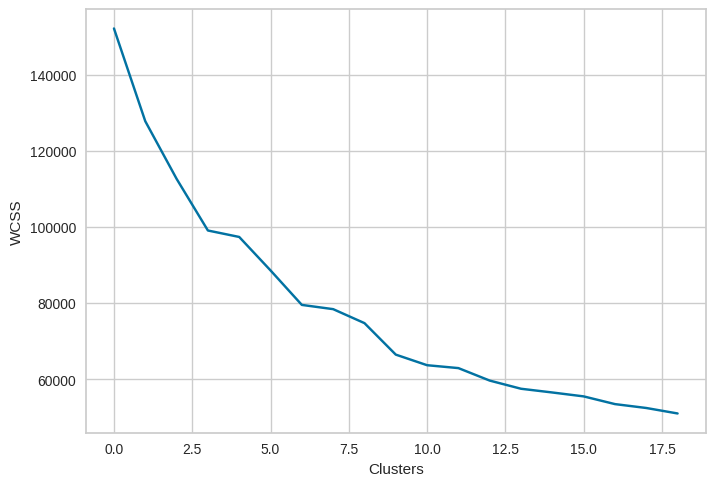

In [33]:
plt.plot(wcss_1, 'bx-')
plt.xlabel('Clusters')
plt.ylabel('WCSS');

## Clusterização com K-Means

In [34]:
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(creditcard_df_scaled)
labels = kmeans.labels_

In [35]:
# labels = grupo para cada um dos clientes
# 0 = cluster 0 para o cliente de índice x
# 1 = cluster 1 para o cliente de índice y
labels, len(labels)

(array([2, 3, 5, ..., 5, 2, 0], dtype=int32), 8950)

In [36]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([1235,  992, 2848,  917,   30, 2347,  581]))

In [37]:
# centroides de cada grupo média de cada atributo dentro do cluster
# 7 vetores: atributo médio de cada um dos clusters:
# vetor 0: [-3.61685928e-01,  3.31481301e-01, -3.03257864e-02, -> -3.6168 = média do saldo da conta corrente para o cluster 0

In [38]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [creditcard_df.columns[1:]])
cluster_centers

BALANCE BALANCE_FREQUENCY  PURCHASES ONEOFF_PURCHASES  \
0 -0.695085         -2.173522  -0.326612        -0.242052   
1 -0.694395          0.090754   0.086872        -0.041380   
2  0.001748          0.372665  -0.365609        -0.242996   
3  1.615263          0.377216  -0.214653        -0.145053   
4  1.923051          0.337717  11.212042        10.600367   
5 -0.177452          0.385932   0.022859        -0.056522   
6  0.713886          0.464549   1.992395         1.674384   

  INSTALLMENTS_PURCHASES CASH_ADVANCE PURCHASES_FREQUENCY  \
0              -0.327456    -0.296768           -0.586523   
1               0.281001    -0.449883            0.897157   
2              -0.417934    -0.055145           -0.907631   
3              -0.241118     1.989602           -0.466261   
4               7.033118     0.419625            1.046983   
5               0.157929    -0.316316            0.912691   
6               1.634849    -0.216206            1.157228   

  ONEOFF_PURCHASES_FREQUENCY PURCHASES_INSTALLMENTS_FREQUENCY  \
0                  -0.448942                        -0.468625   
1                   0.245053                         0.739284   
2                  -0.407690                        -0.805532   
3                  -0.171251                        -0.434925   
4                   1.915501                         0.981334   
5                   0.236653                         0.803469   
6                   1.739439                         1.070432   

  CASH_ADVANCE_FREQUENCY CASH_ADVANCE_TRX PURCHASES_TRX CREDIT_LIMIT  \
0              -0.469555        -0.348400     -0.436376    -0.242217   
1              -0.641563        -0.459475      0.170240     0.048380   
2               0.176814        -0.001423     -0.500117    -0.328408   
3               1.927680         1.896949     -0.268322     0.987149   
4              -0.258912         0.061229      5.362438     3.044064   
5              -0.367523        -0.305361      0.214871    -0.208235   
6              -0.319433        -0.232845      2.352105     1.159964   

   PAYMENTS MINIMUM_PAYMENTS PRC_FULL_PAYMENT    TENURE  
0 -0.226855        -0.252655         0.067453 -0.171163  
1 -0.151768        -0.294906         2.181470 -0.098696  
2 -0.261537        -0.028118        -0.451648 -0.013991  
3  0.776927         0.521767        -0.391009 -0.088317  
4  8.098975         1.120318         1.110132  0.310863  
5 -0.179053        -0.001354        -0.332269  0.102362  
6  1.093622         0.298938         0.256867  0.308309

- Grupo 0 (VIP/Prime): limite do cartão alto (15570) e o mais alto percentual de pagamento da fatura completa (0.47). Aumentar o limite do cartão e o hábito de compras

- Grupo 3: Clientes que pagam poucos juros para o banco e são cuidadosos com seu dinheiro. Possui menos dinheiro na conta corrente (104) e não sacam muito dinheiro do limite do cartão (302). 23% de pagamento da fatura completa do cartão de crédito

- Grupo 5: usam o cartão de crédito como "empréstimo" (setor mais lucrativo para o banco), possuem muito dinheiro na conta corrente (5119) e sacam muito dinheiro do cartão de crédito (5246), compram pouco (0.3) e usam bastante o limite do cartão para saques (0.51). Pagam muito pouco a fatura completa (0.03)

- Grupo 7 (clientes novos): clientes mais novos (7.23) e que mantém pouco dinheiro na conta corrente (863 dólar)

In [39]:
cluster_centers = scaler.inverse_transform(cluster_centers) # transforma para números mais reais, pelo algoritmo, de cada cluster em relação a cada coluna/característica
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [creditcard_df.columns[1:]])
cluster_centers

BALANCE BALANCE_FREQUENCY     PURCHASES ONEOFF_PURCHASES  \
0   117.713546          0.362383    305.393725       190.680891   
1   119.150057          0.898769   1188.807927       523.755035   
2  1568.113840          0.965552    222.075330       189.114192   
3  4926.508920          0.966630    544.595823       351.679258   
4  5567.142164          0.957273  24957.905000     18186.875667   
5  1195.122637          0.968694   1052.044382       498.621786   
6  3050.367871          0.987318   5259.987675      3371.572239   

  INSTALLMENTS_PURCHASES CASH_ADVANCE PURCHASES_FREQUENCY  \
0             114.953158   356.534100            0.254951   
1             665.173195    35.446401            0.850423   
2              33.134902   863.229758            0.126074   
3             193.027437  5151.159978            0.303218   
4            6771.029333  1858.844605            0.910556   
5             553.880524   315.540819            0.856658   
6            1889.441077   525.477269            0.954802   

  ONEOFF_PURCHASES_FREQUENCY PURCHASES_INSTALLMENTS_FREQUENCY  \
0                   0.068529                         0.178194   
1                   0.275562                         0.658248   
2                   0.080836                         0.044298   
3                   0.151370                         0.191587   
4                   0.773889                         0.754444   
5                   0.273056                         0.683757   
6                   0.721366                         0.789854   

  CASH_ADVANCE_FREQUENCY CASH_ADVANCE_TRX PURCHASES_TRX  CREDIT_LIMIT  \
0               0.041181         0.871255      3.863158   3613.165096   
1               0.006761         0.113246     18.941355   4670.474768   
2               0.170527         3.239115      2.278792   3299.566948   
3               0.520893        16.194111      8.040349   8086.100922   
4               0.083333         3.666667    148.000000  15570.000000   
5               0.061599         1.164962     20.050725   3736.804318   
6               0.071222         1.659829     73.174359   8714.871795   

       PAYMENTS MINIMUM_PAYMENTS PRC_FULL_PAYMENT     TENURE  
0   1076.419707       275.404102         0.173443  11.288259  
1   1293.790366       176.940202         0.791757  11.385238  
2    976.020845       798.678667         0.021615  11.498596  
3   3982.270217      2080.163676         0.039351  11.399128  
4  25178.882690      3475.059479         0.478409  11.933333  
5   1214.802746       861.050157         0.056532  11.654305  
6   4899.072798      1560.868788         0.228844  11.929915

Grupo 2 (VIP/Prime): limite do cartão alto (15570) e o mais alto percentual de pagamento da fatura completa (0.47). Aumentar o limite do cartão e o hábito de compras

Grupo 3: Clientes que pagam poucos juros para o banco e são cuidadosos com seu dinheiro. Possui menos dinheiro na conta corrente (104) e não sacam muito dinheiro do limite do cartão (302). 23% de pagamento da fatura completa do cartão de crédito

Grupo 1: usam o cartão de crédito como "empréstimo" (setor mais lucrativo para o banco), possuem muito dinheiro na conta corrente (5019.320038) e sacam muito dinheiro do cartão de crédito (5146.300575), compram pouco (0.295890) e usam bastante o limite do cartão para saques (0.518819). Pagam muito pouco a fatura completa (0.03)

Grupo 7 (clientes novos): clientes mais novos (7.23) e que mantém pouco dinheiro na conta corrente (863 dólar)

In [40]:
X = pd.DataFrame(creditcard_df_scaled)
X = np.asarray(X)

kmeans = KMeans(n_clusters=n_clusters, random_state=32, max_iter=200)
y_kmeans = kmeans.fit_predict(X)

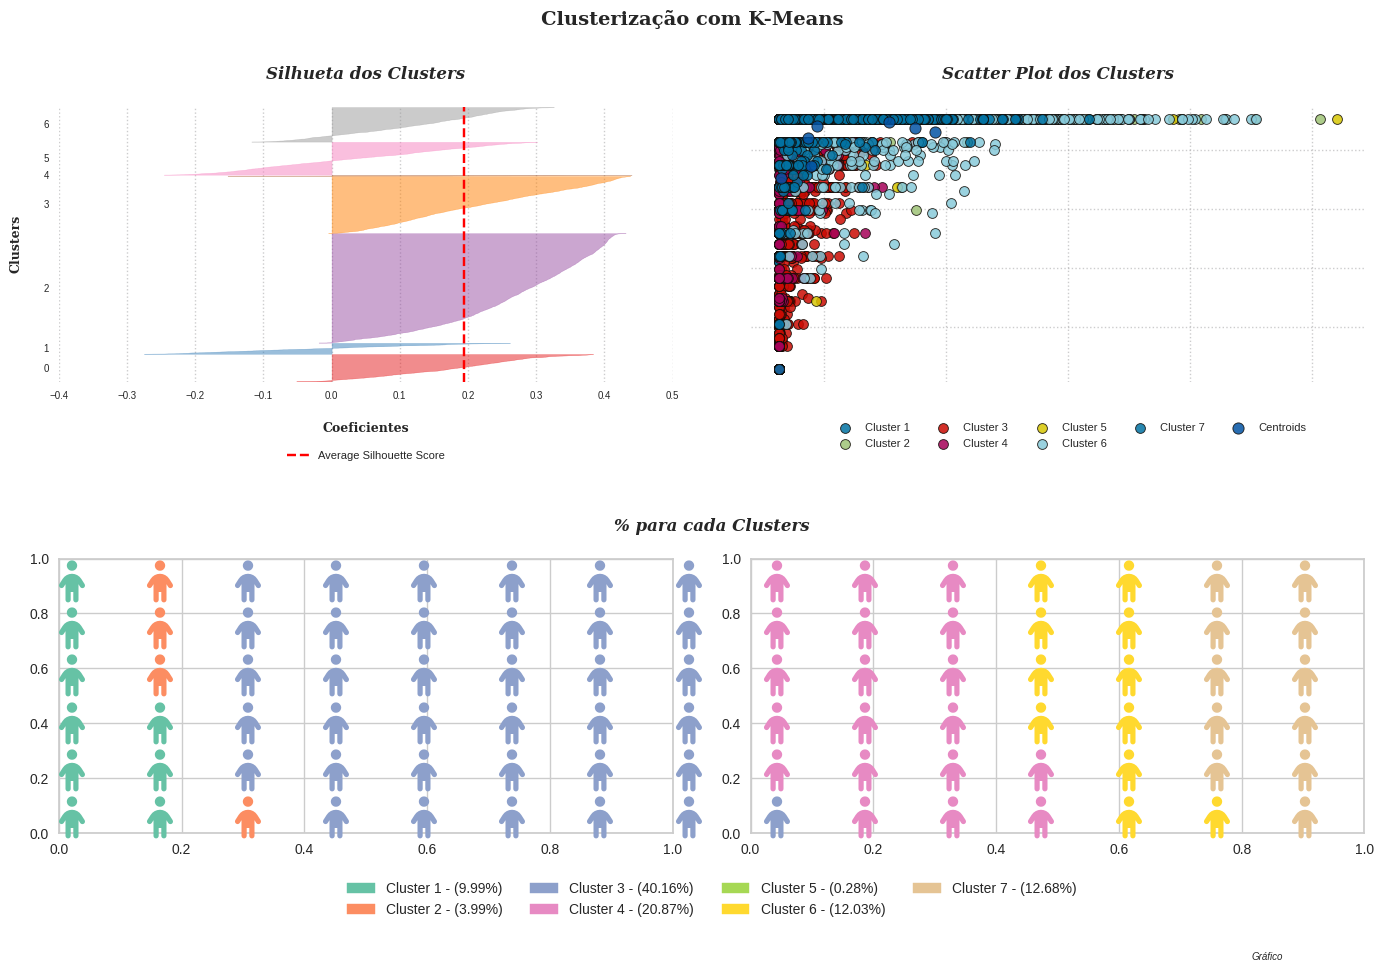

In [41]:
def generate_plots_cluster(kmeans, y_kmeans):
    labels = [f'Cluster {x}' for x in range(1,n_clusters+1)] + ['Centroids']
    title=dict(fontsize=12, fontweight='bold', style='italic', fontfamily='serif')
    text_style=dict(fontweight='bold', fontfamily='serif')
    scatter_style=dict(linewidth=0.65, edgecolor='#100C07', alpha=0.85)
    legend_style=dict(borderpad=2, frameon=False, fontsize=8)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

    # Silhouette
    s_viz = SilhouetteVisualizer(kmeans, ax=ax1)
    s_viz.fit(X)
    s_viz.finalize()
    s_viz.ax.set_title('Silhueta dos Clusters\n', title)
    s_viz.ax.tick_params(labelsize=7)
    for text in s_viz.ax.legend_.texts:
        text.set_fontsize(9)
    for spine in s_viz.ax.spines.values():
        spine.set_color('None')
    s_viz.ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), **legend_style)
    s_viz.ax.grid(axis='x', alpha=0.5, color='#9B9A9C', linestyle='dotted')
    s_viz.ax.grid(axis='y', alpha=0)
    s_viz.ax.set_xlabel('\nCoeficientes', fontsize=9, **text_style)
    s_viz.ax.set_ylabel('Clusters\n', fontsize=9, **text_style)

    # Clusters Distribuição
    y_kmeans_labels = list(set(y_kmeans.tolist()))
    for i in y_kmeans_labels:
        ax2.scatter(X[y_kmeans==i, 0], X[y_kmeans == i, 1], s=50, **scatter_style)
    ax2.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=65, c='#0353A4', label='Centroids', **scatter_style)
    for spine in ax2.spines.values():
        spine.set_color('None')
    ax2.set_title('Scatter Plot dos Clusters\n', **title)
    ax2.legend(labels, bbox_to_anchor=(0.95, -0.05), ncol=5, **legend_style)
    ax2.grid(axis='both', alpha=0.5, color='#9B9A9C', linestyle='dotted')
    ax2.tick_params(left=False, right=False , labelleft=False , labelbottom=False, bottom=False)
    ax2.spines['bottom'].set_visible(True)

    # Waffle Chart
    unique, counts = np.unique(y_kmeans, return_counts=True)
    df_waffle = dict(zip(unique, counts))
    total = sum(df_waffle.values())
    wfl_square = {key: value/100 for key, value in df_waffle.items()}
    wfl_label = {key: round(value/total*100, 2) for key, value in df_waffle.items()}

    ax3=plt.subplot(2, 2, (3,4))
    ax3.set_title('% para cada Clusters\n', **title)
    ax3.set_aspect(aspect='auto')
    Waffle.make_waffle(ax=ax3, rows=6, values=wfl_square,
                       labels=[f"Cluster {i+1} - ({k}%)" for i, k in wfl_label.items()], icons='child', icon_size=30,
                       legend={'loc': 'upper center', 'bbox_to_anchor': (0.5, -0.05), 'ncol': 4, 'borderpad': 2,
                               'frameon': False, 'fontsize':10})

    plt.suptitle('Clusterização com K-Means\n', fontsize=14, **text_style)
    plt.gcf().text(0.9, 0.03, 'Gráfico', style='italic', fontsize=7)
    plt.tight_layout()
    plt.show()

generate_plots_cluster(kmeans, y_kmeans);

In [42]:
# cria um novo dataframe, concatenando os dados originais com o número de cluster
creditcard_df_cluster = pd.concat([creditcard_df, pd.DataFrame({'cluster': labels})], axis = 1)
creditcard_df_cluster.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  cluster  
0   201.802084        139.509787          0.000000      12        2  
1  4103.032597       1072.340217          0.222222      12        3  
2   622.066742        627.284787          0.000000      12        5  
3     0.000000        864.206542          0.000000      12        2  
4   678.334763        244.791237          0.000000      12        2

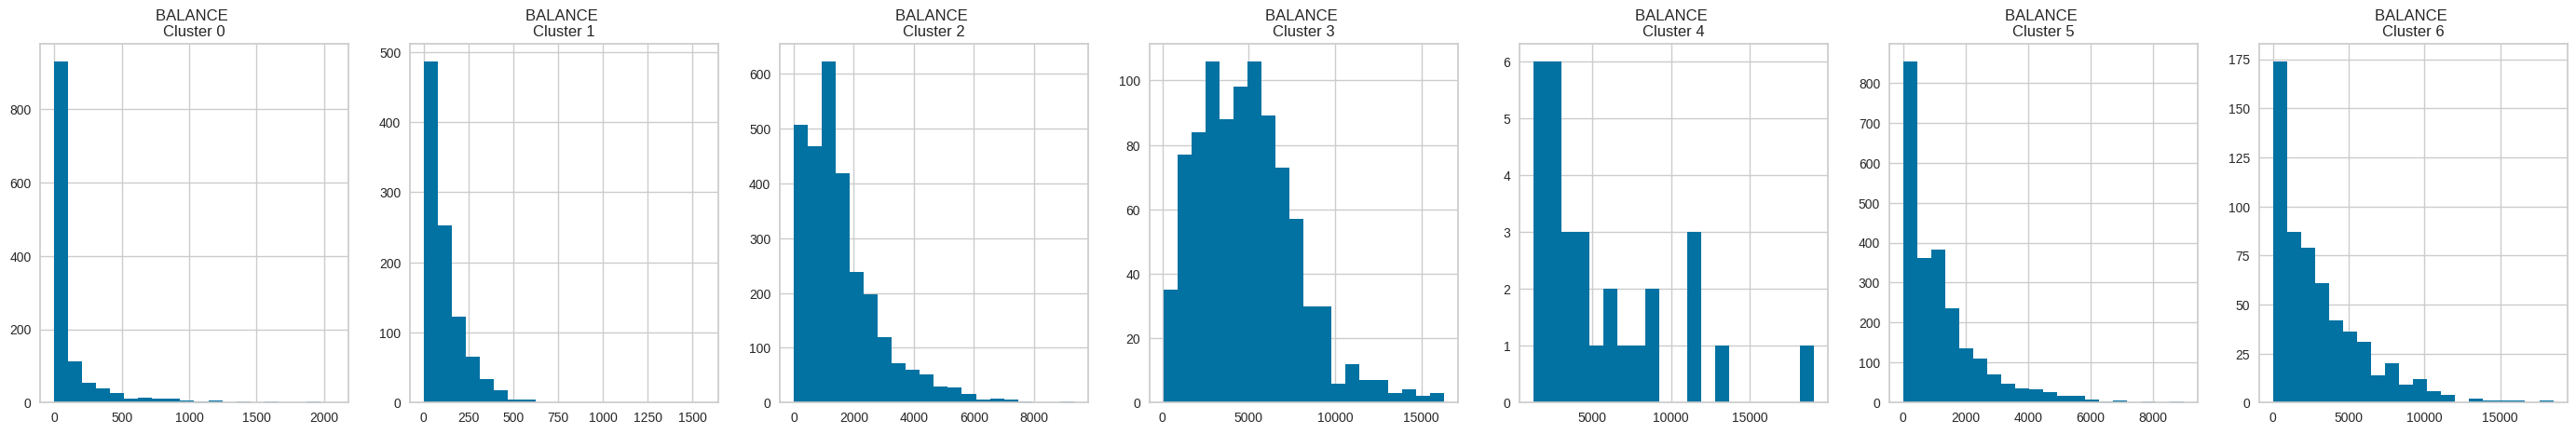

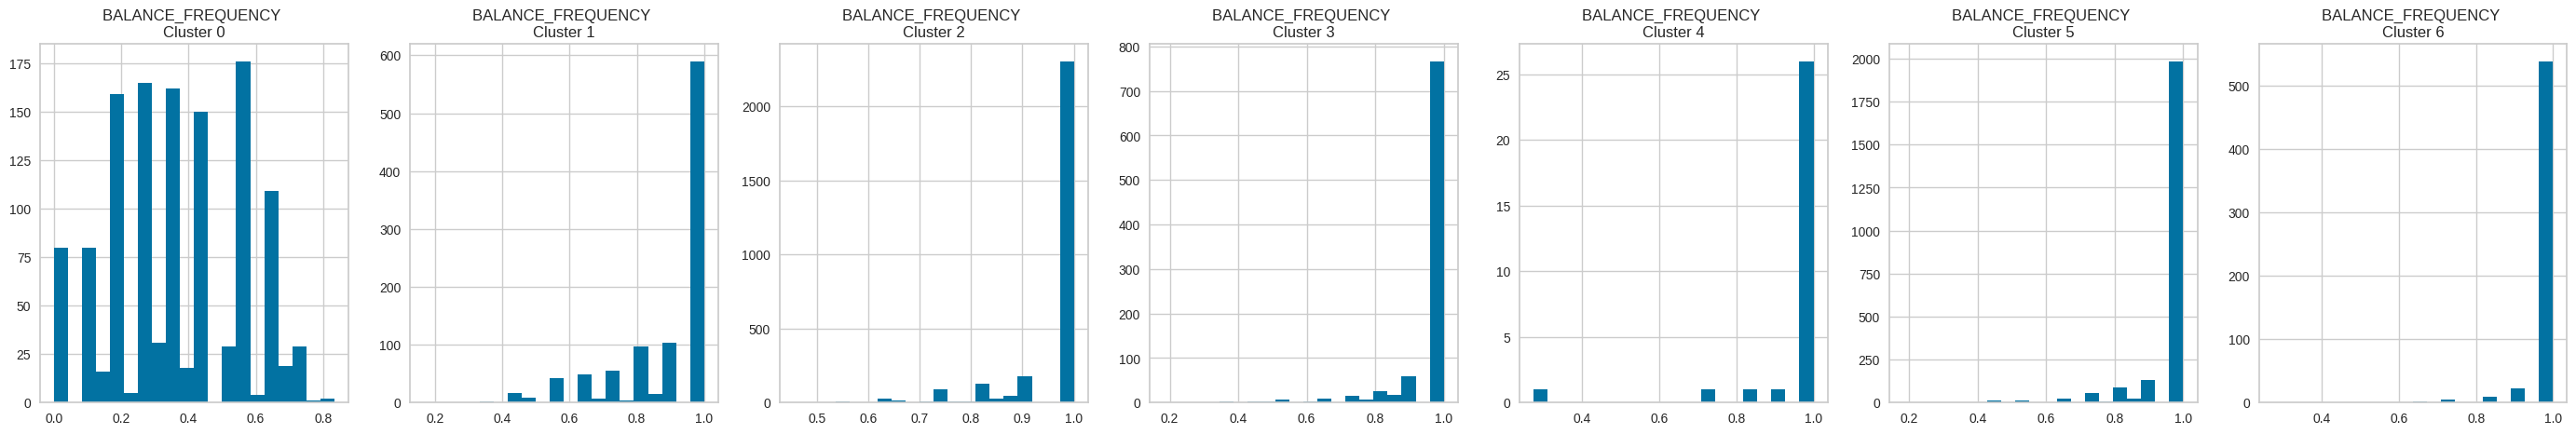

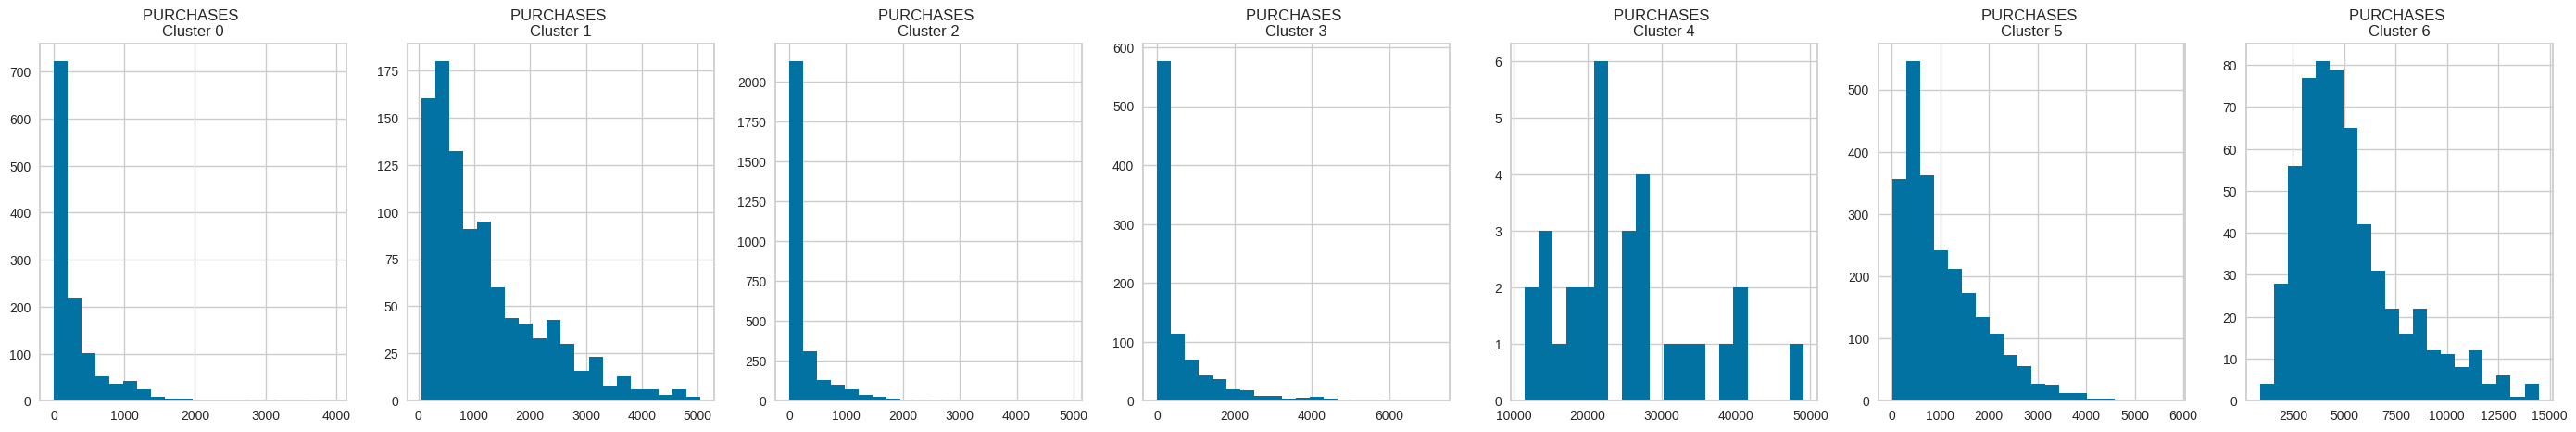

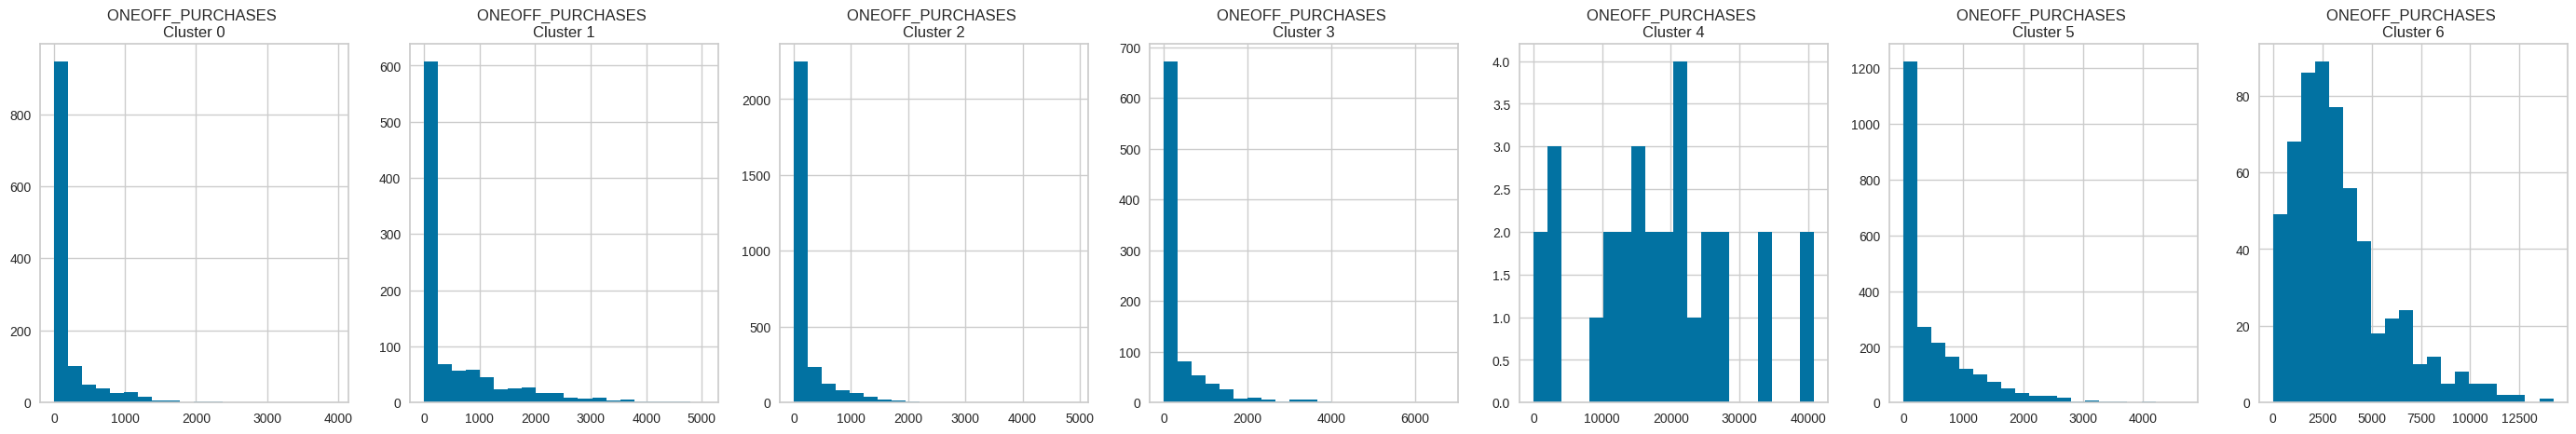

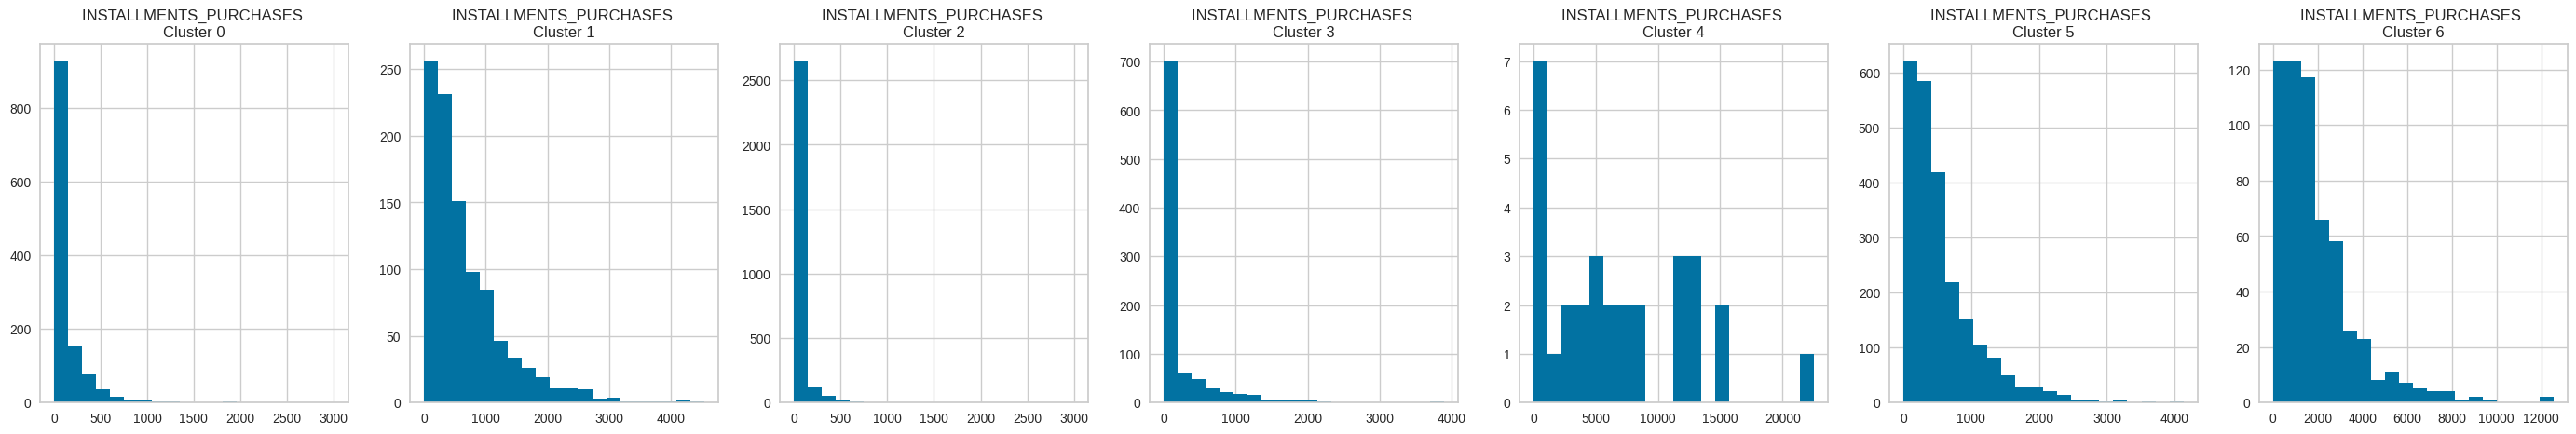

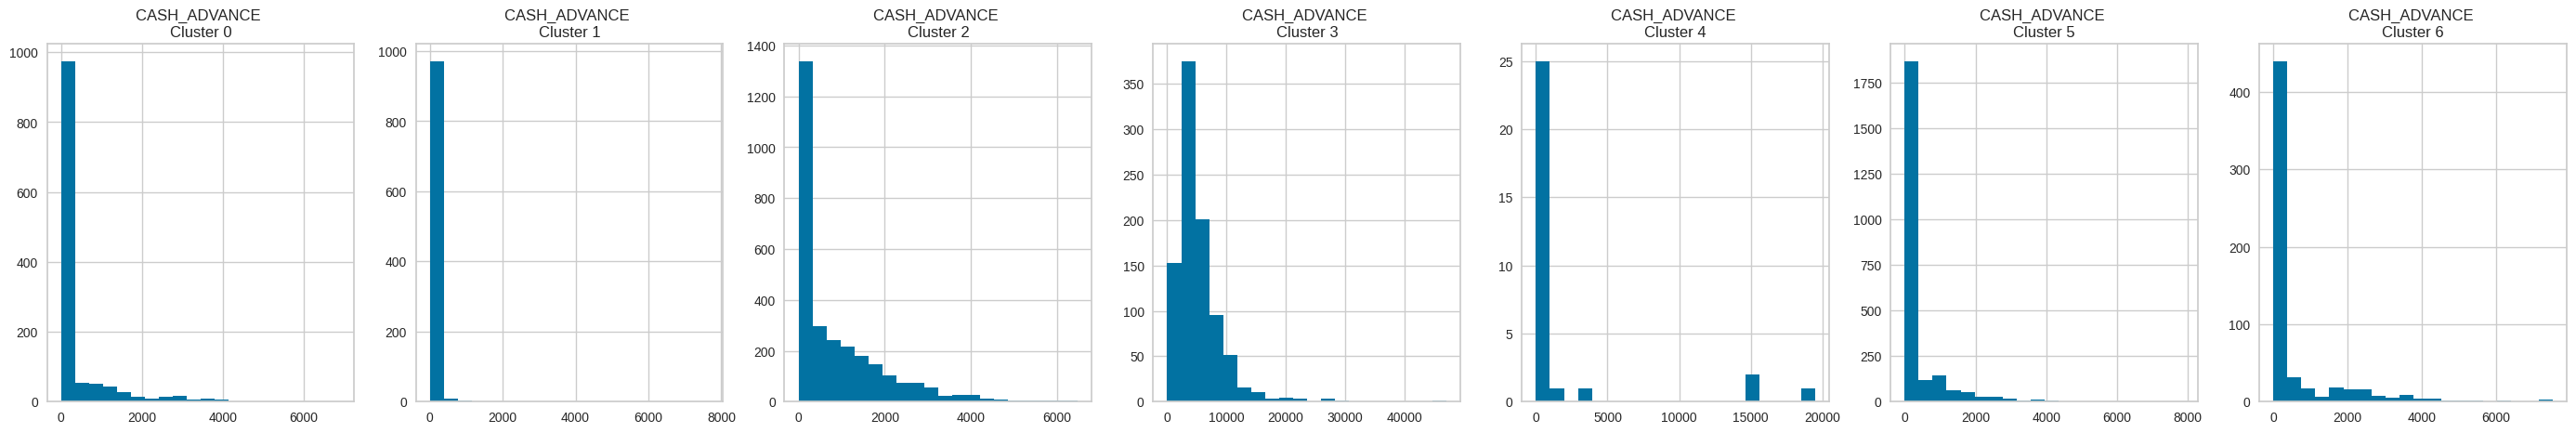

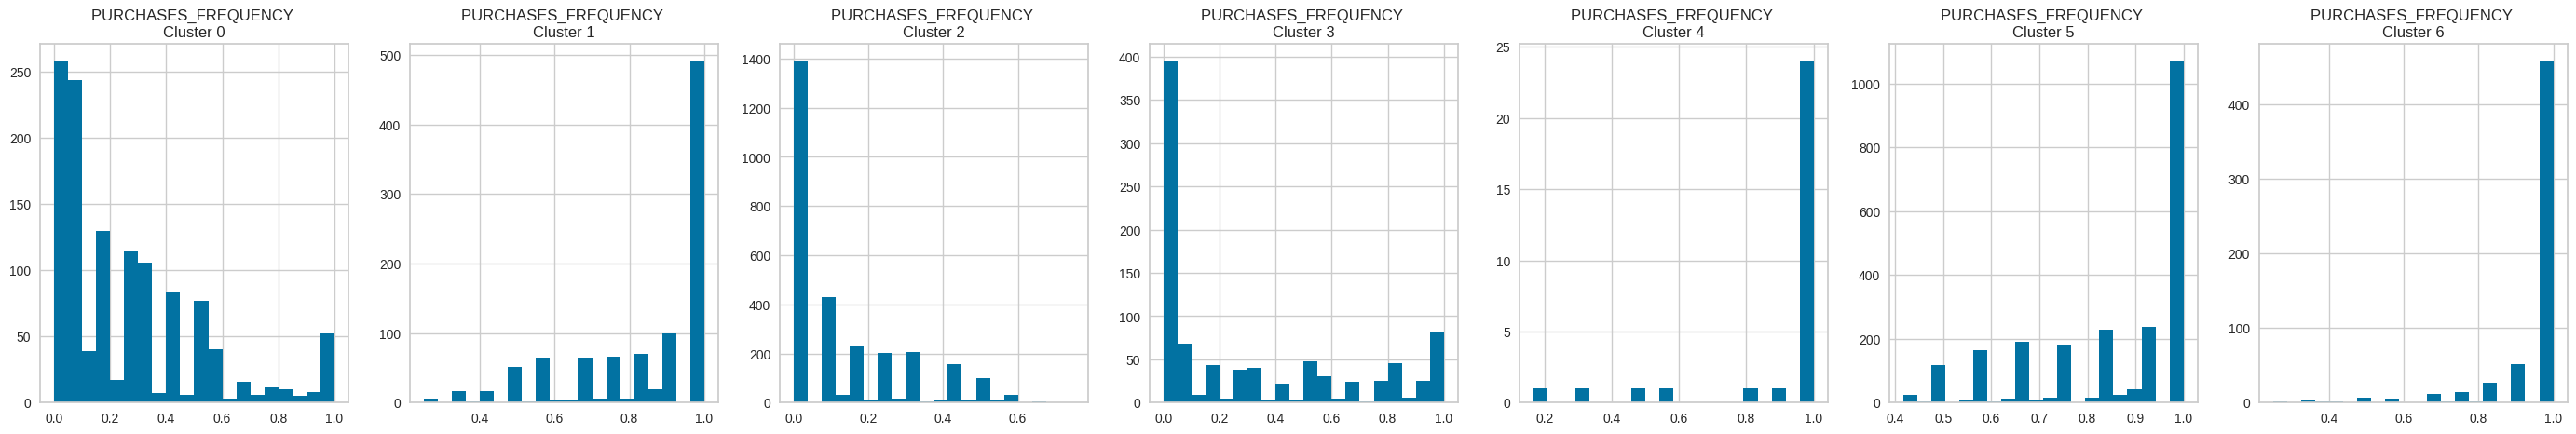

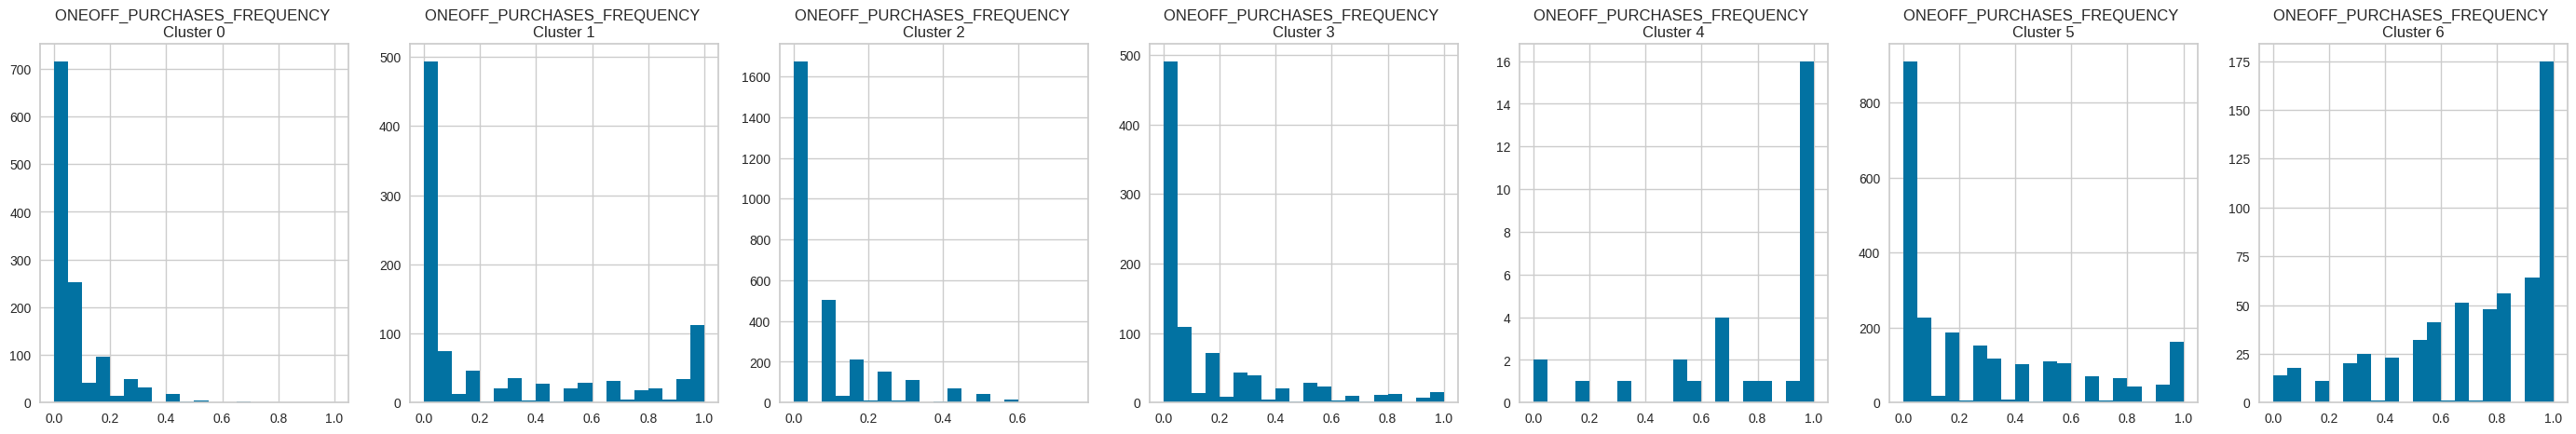

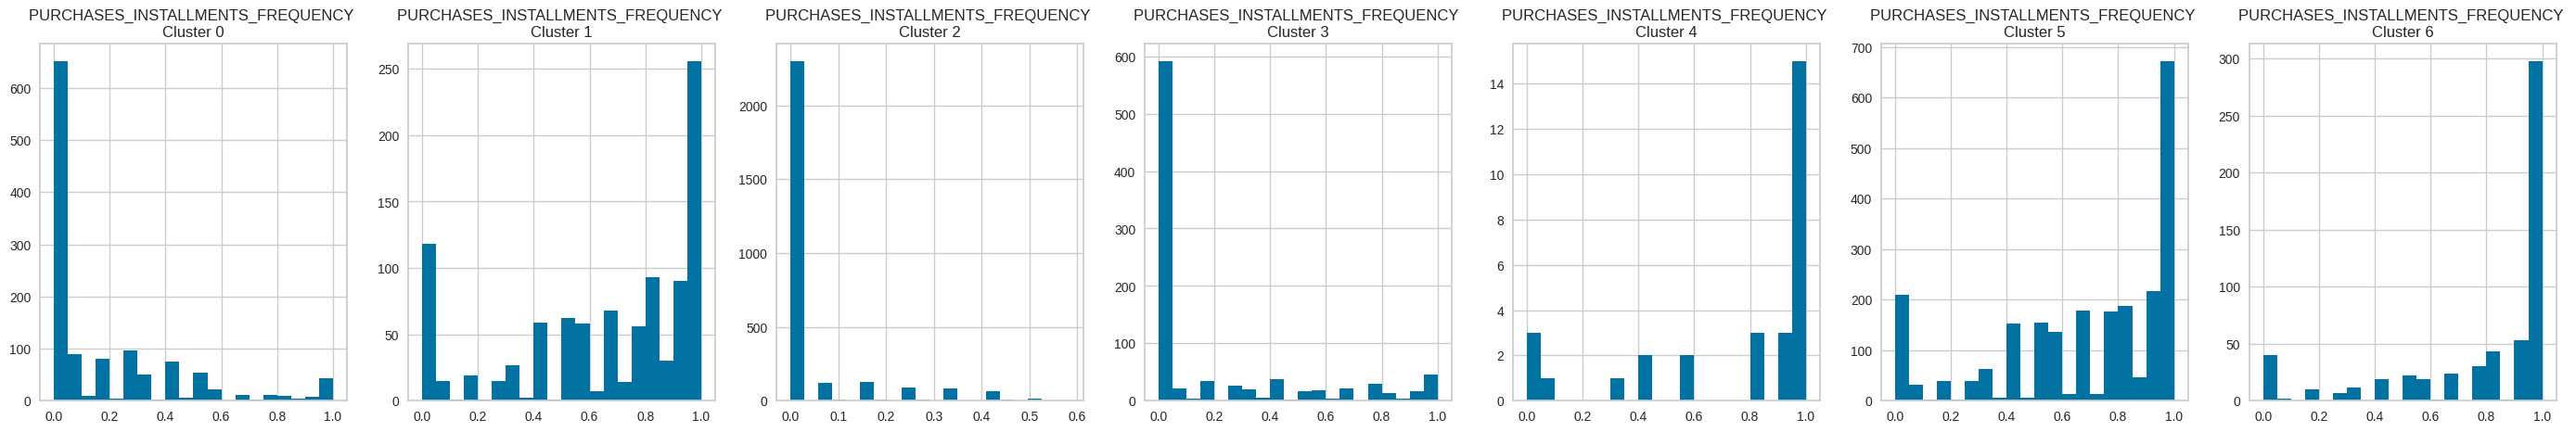

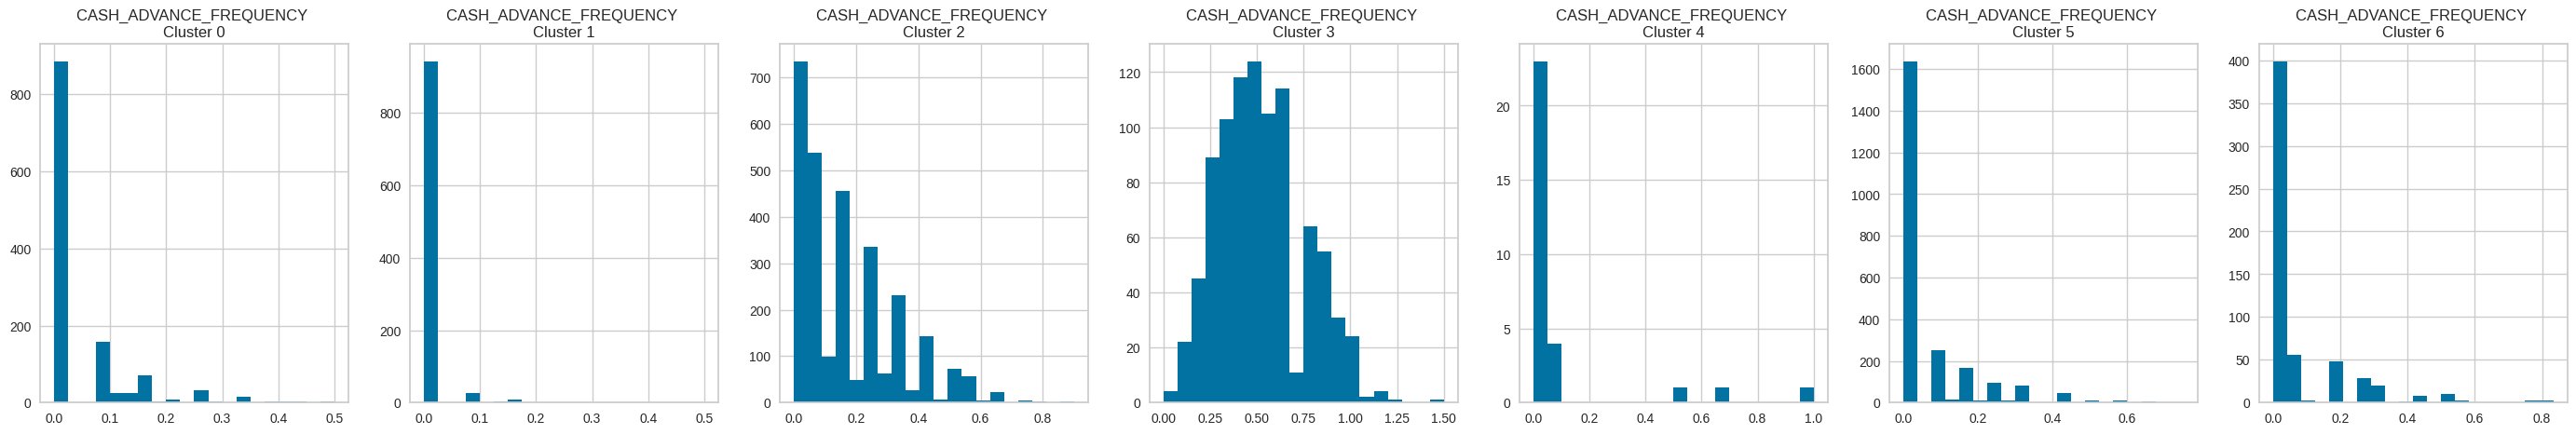

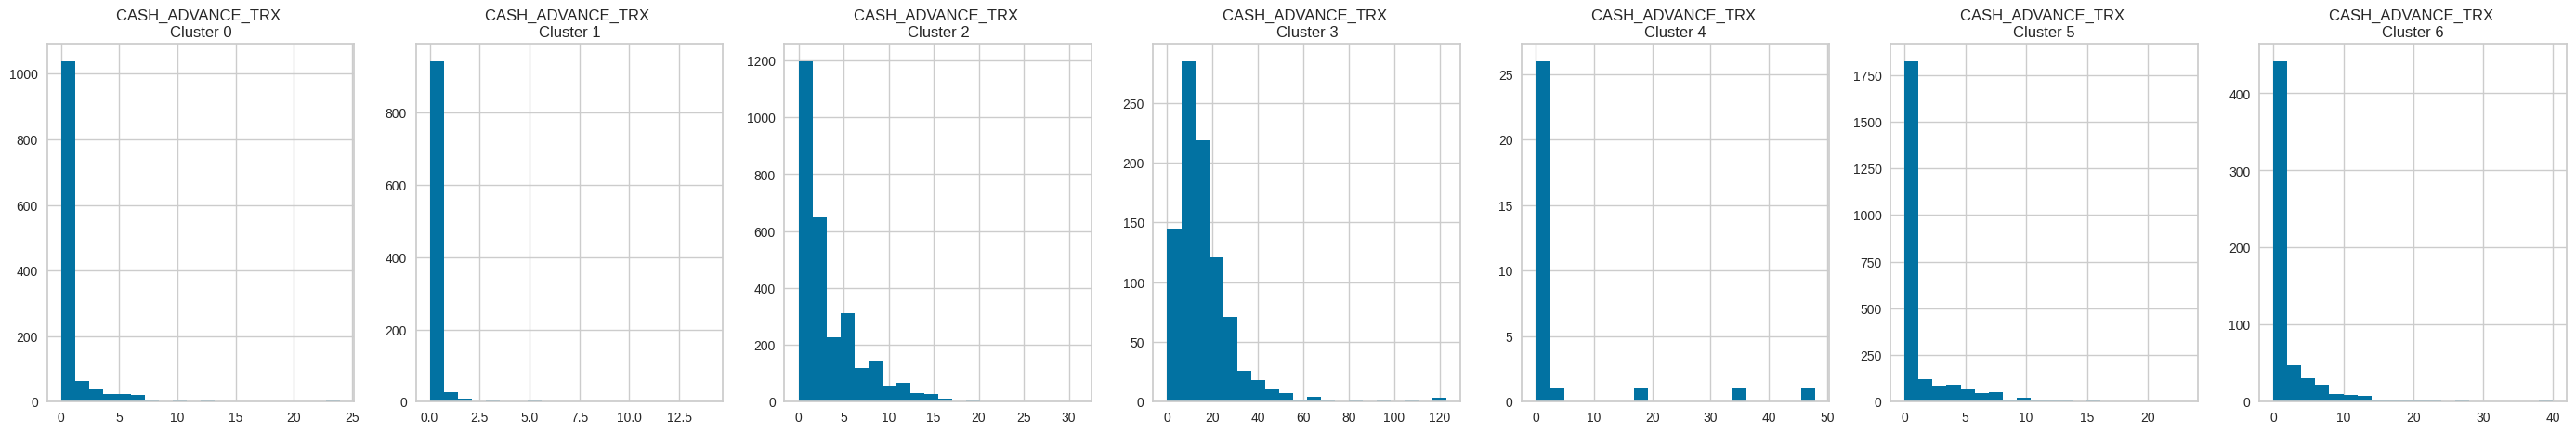

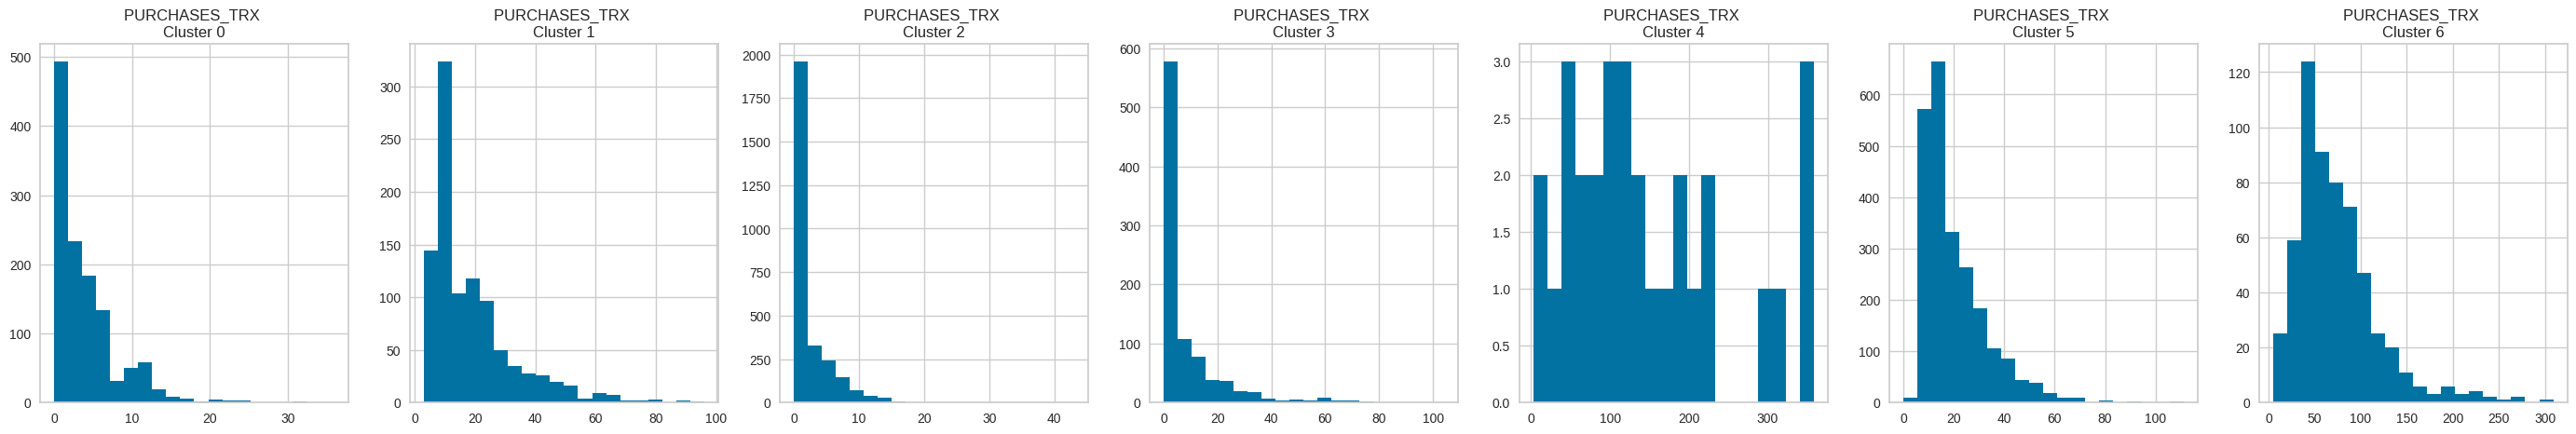

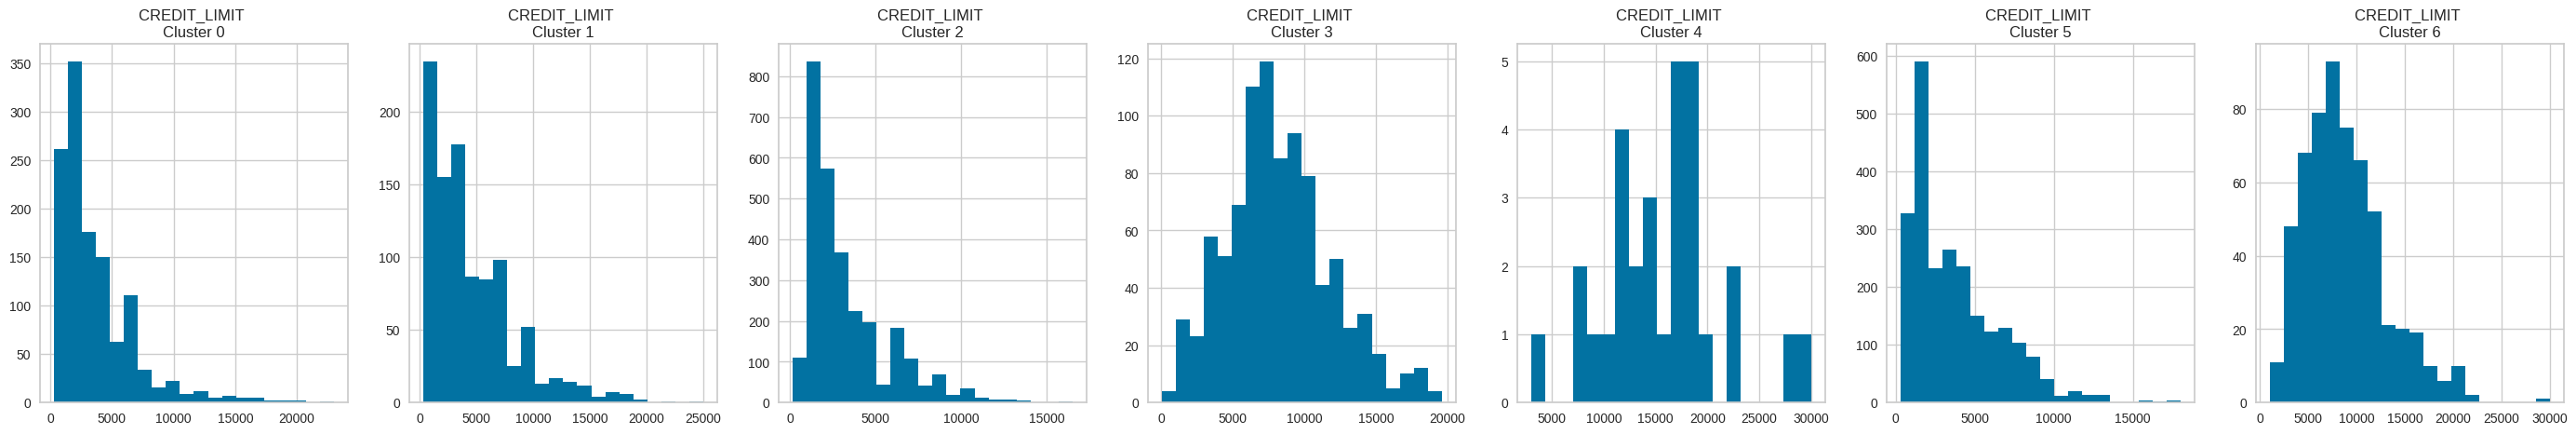

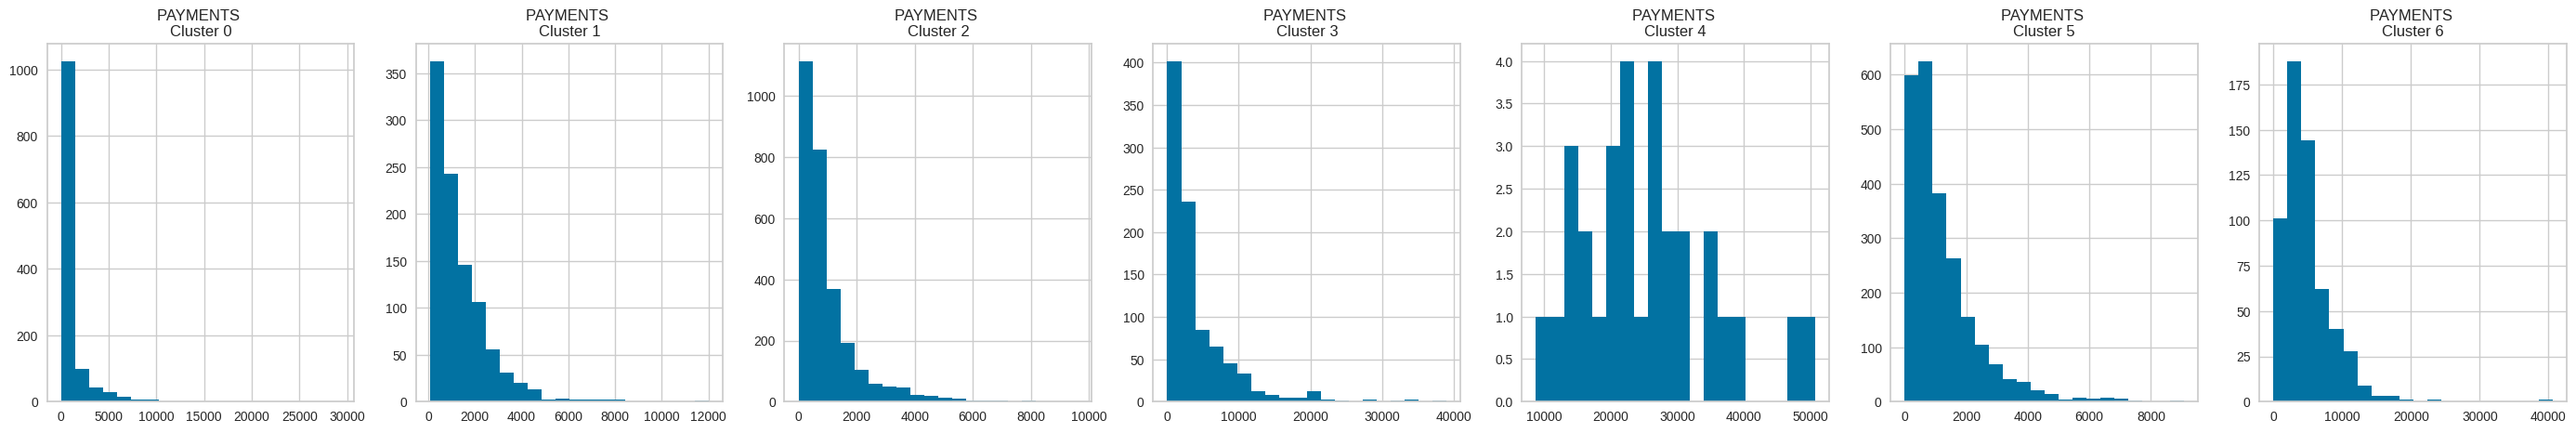

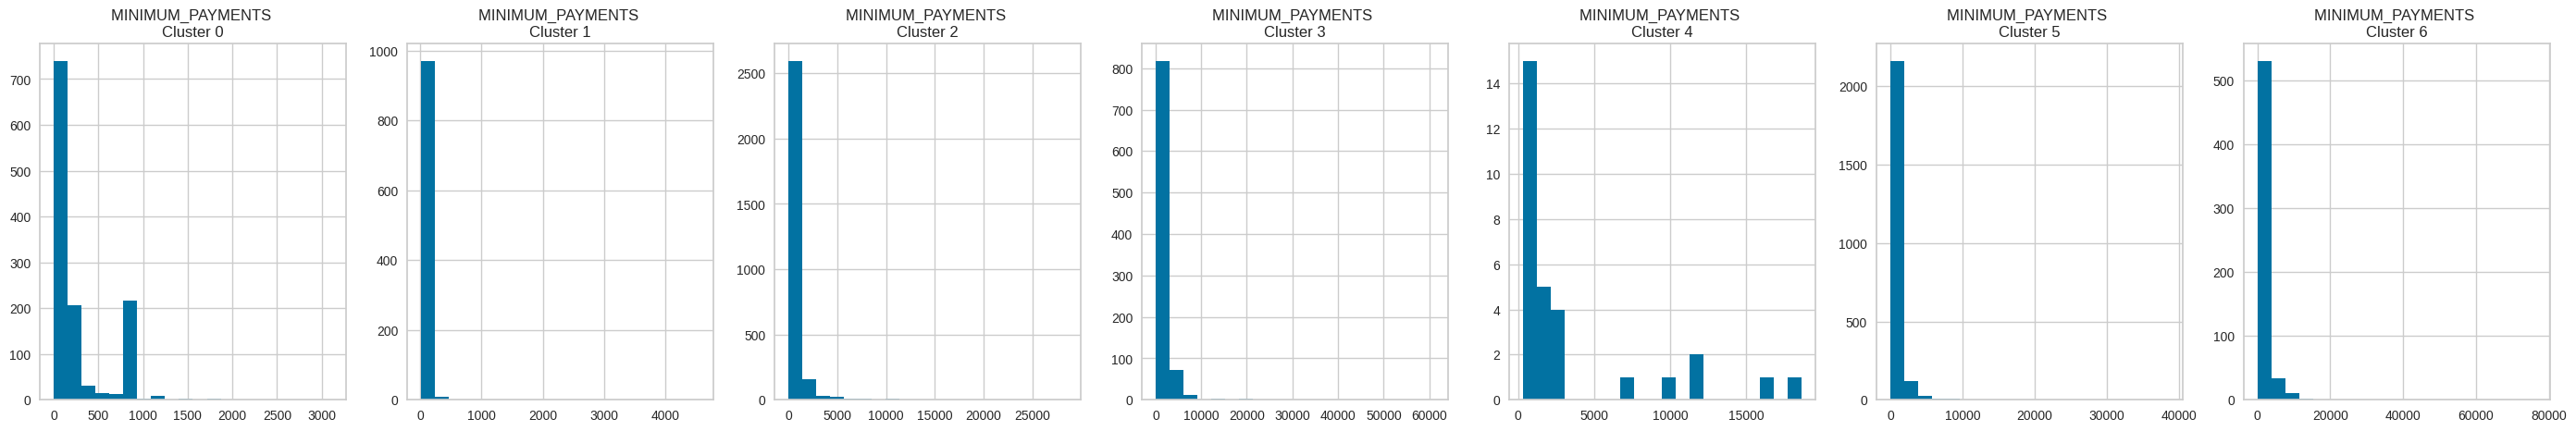

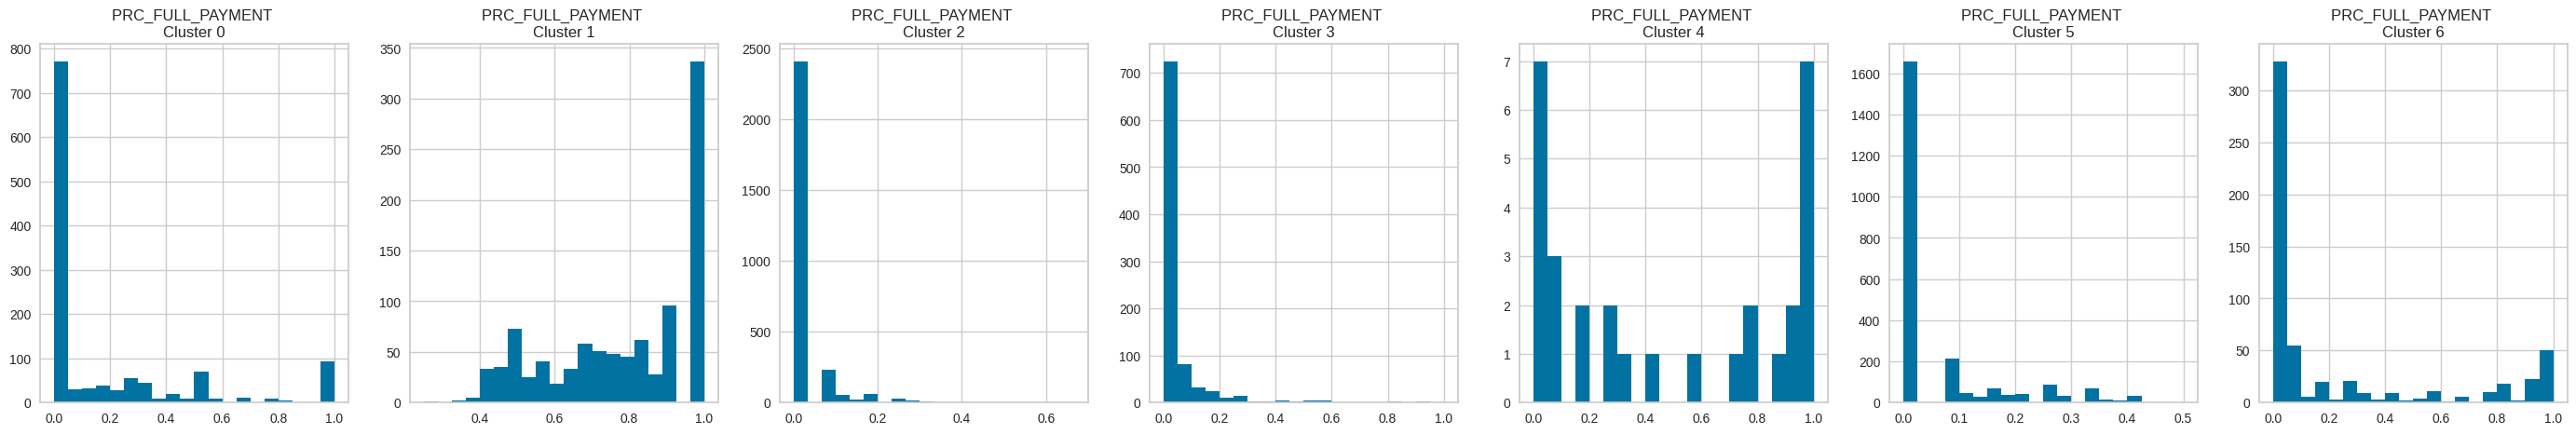

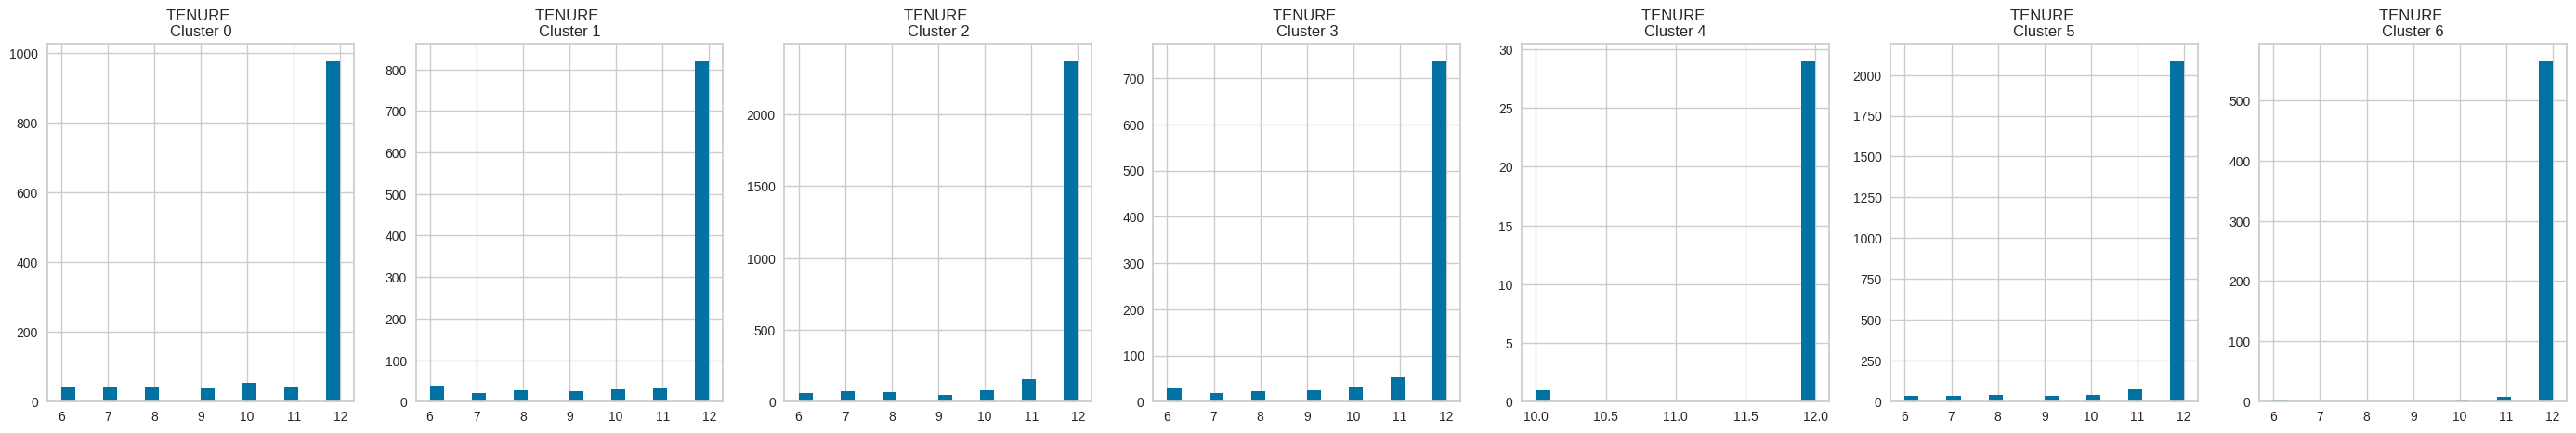

In [43]:
# gera histograma pra cada um dos clusters de cada coluna da tabela
for i in creditcard_df.drop(columns=['CUST_ID']).columns:
  plt.figure(figsize=(35,5))
  for j in range(n_clusters):
    plt.subplot(1, n_clusters, j + 1)
    cluster = creditcard_df_cluster[creditcard_df_cluster['cluster'] == j]
    cluster[i].hist(bins = 20)
    plt.title('{} \nCluster {}'.format(i, j))
  plt.show()

In [44]:
credit_ordered = creditcard_df_cluster.sort_values(by = 'cluster')
credit_ordered.head()

CUST_ID     BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
8949  C19190  372.708075           0.666667    1093.25           1093.25   
3070  C13159    0.000000           0.000000      63.30              0.00   
7664  C17870    0.570113           0.090909      29.00             29.00   
6337  C16512   50.571196           0.545455     499.98              0.00   
2073  C12139    8.048086           0.272727      55.50              0.00   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
8949                    0.00    127.040008             0.666667   
3070                   63.30      0.000000             0.250000   
7664                    0.00      0.000000             0.083333   
6337                  499.98      0.000000             0.500000   
2073                   55.50      0.000000             0.166667   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
8949                    0.666667                          0.000000   
3070                    0.000000                          0.250000   
7664                    0.083333                          0.000000   
6337                    0.000000                          0.416667   
2073                    0.000000                          0.166667   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
8949                0.333333                 2             23        1200.0   
3070                0.000000                 0              3        2700.0   
7664                0.000000                 0              1        2500.0   
6337                0.000000                 0              6        2500.0   
2073                0.000000                 0              2        1200.0   

        PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  cluster  
8949   63.165404         88.288956               0.0       6        0  
3070    0.000000        864.206542               0.0      12        0  
7664  319.172687        864.206542               0.0      12        0  
6337  744.260461        235.440351               0.2      12        0  
2073  318.843744        126.009475               0.0      12        0

In [45]:
credit_ordered.tail()

CUST_ID       BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
1767  C11827  10822.058110                1.0    4850.35           2847.80   
3788  C13896   4199.989868                1.0   11653.14           6884.60   
3093  C13183   6773.941979                1.0   14215.00          14215.00   
373   C10385   1128.229387                1.0    5068.88           3529.88   
4919  C15056   4766.360515                1.0    2894.04           2583.82   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
1767                 2002.55      0.000000             1.000000   
3788                 4768.54      0.000000             0.916667   
3093                    0.00    464.795495             0.583333   
373                  1539.00      0.000000             1.000000   
4919                  310.22   1386.851165             1.000000   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
1767                    0.916667                          1.000000   
3788                    1.000000                          0.916667   
3093                    0.583333                          0.000000   
373                     1.000000                          1.000000   
4919                    1.000000                          0.416667   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
1767                0.000000                 0            208       15500.0   
3788                0.000000                 0             84       16500.0   
3093                0.083333                 1             30        9000.0   
373                 0.000000                 0             76        4500.0   
4919                0.166667                 2             34       20000.0   

          PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  cluster  
1767   2740.094420       2621.071099          0.000000      12        6  
3788  13660.241200       1056.912965          0.000000      12        6  
3093   5773.661106       6338.527589          0.000000      12        6  
373    3904.568067        373.931063          0.083333      12        6  
4919   1302.793390       1245.948419          0.000000      12        6

## Aplicação de PCA (principal component analysis)

PCA: não supervisionado
Redução de dimensionalidade: se há 3 dimensões, é feito um
cálculo para reduzir para 2 dimensões. Tenta manter as mesmas características

Os componenetes são criadas com as características não-correlacionadas. Mantém a característica

Se, na matriz de correlação tiver uma relação forte, o PCA irá unir esses dois para que se tenha um atributo só

OU SEJA, se há uma correlação forte, JUNTA, ex: 0.86
        se não há uma correlação forte, mantém elas, ou seja, o PCA prioriza características que não estão correlacionadas, ex: 0.2


In [46]:
pca = PCA(n_components=2) # numéro de componentes irá gerar. Como o objeto é gerar um gráfico, pega as 18 características inicias e transforma em apenas 2
principal_comp = pca.fit_transform(creditcard_df_scaled) # dados originais

In [47]:
# aquelas 18 características da tabela, agora serão apenas 2
pca_df = pd.DataFrame(data = principal_comp, columns=['pca1', 'pca2'])
pca_df.head()

pca1      pca2
0 -1.682220 -1.076451
1 -1.138295  2.506477
2  0.969684 -0.383520
3 -0.873628  0.043166
4 -1.599434 -0.688581

In [48]:
pca_df.shape

(8950, 2)

In [49]:
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster': labels})], axis = 1)
pca_df.head()

pca1      pca2  cluster
0 -1.682220 -1.076451        2
1 -1.138295  2.506477        3
2  0.969684 -0.383520        5
3 -0.873628  0.043166        2
4 -1.599434 -0.688581        2

<ipython-input-50-ccb668df423f>:2: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.scatterplot(x = 'pca1', y = 'pca2', hue = 'cluster', data = pca_df, palette = ['red', 'green', 'blue', 'pink', 'yellow', 'gray', 'purple', 'black'])


<Axes: xlabel='pca1', ylabel='pca2'>

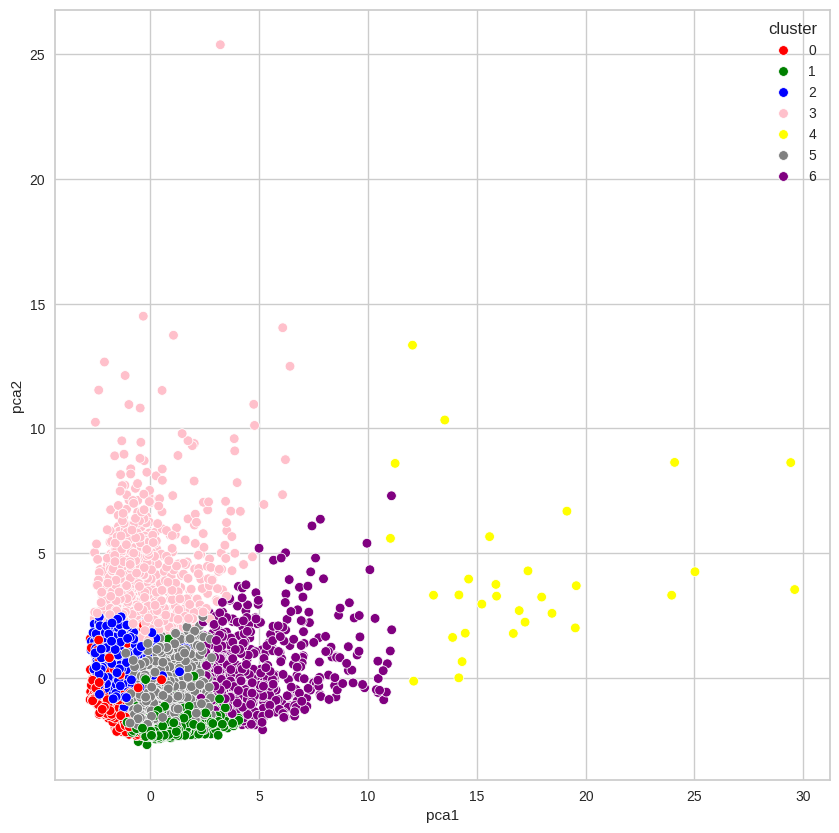

In [50]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = 'pca1', y = 'pca2', hue = 'cluster', data = pca_df, palette = ['red', 'green', 'blue', 'pink', 'yellow', 'gray', 'purple', 'black'])

## Aplicação de autoencoders

Tipo de rede neural para codificar dados

Utiliza a mesma entrada e saída para comprar resultados

Comprime a informação no meio da rede neural

Funciona se exister uma correlação entre os dados.
Se não tiver, terá resutlador ruins

PCA ou AUTOENCODERS = são concorrentes, pode usar qualquer um ou os dois juntos

Abordar mais técnicas computacionais, pode melhorar os resultados

In [51]:
# 17 entrada-> 500 neuronios-> 200 neuronios -> 8 neuronio que armazena a info codificada -> 200 -> 500  decodificação-> 17
# 17 -> 500 -> 200 -> 8 -> 200 -> 500 -> 17
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [52]:
#cria todas as camadas
#como tem poucos dados, é legal aumentar os neurônios posteriores
# Dense: cada neuronio de uma camada está ligado com todos os neuronios da próximo camada


input_df = Input(shape=(17,)) #inicia com 17 neuronios de entrada, pois são as 17 colunas
x = Dense(500, activation='relu')(input_df)
x = Dense(200, activation='relu')(x)

encoded = Dense(8, activation='relu')(x)

x = Dense(200, activation='relu')(encoded)
x = Dense(500, activation='relu')(x)

decoded = Dense(17)(x)

In [53]:
# processo completo: início, codificação até os 8 neurônios e fazer a decodificação
# autoencoder
autoencoder = Model(input_df, decoded) #camada inicial e final

In [54]:
# somento o encoder: armazena somente a codificação dos dados nos 8 neuronios(encoded)
# encoder
encoder = Model(input_df, encoded)

In [55]:
autoencoder.compile(optimizer = 'Adam', loss = 'mean_squared_error')
# loos = erro -> mean_squared_error = erro ao quadrado: se no início é 100 e chegou ao final com 300, significa que o erro é de 200, ao quadrado

In [56]:
#efetiva o treinamento
#autoencoder.fit(x,x) = compara a entrada com a própria entrada
autoencoder.fit(creditcard_df_scaled, creditcard_df_scaled, epochs = 20)

Epoch 1/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.3777
Epoch 2/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0744
Epoch 3/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0563
Epoch 4/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0440
Epoch 5/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0442
Epoch 6/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0363
Epoch 7/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0313
Epoch 8/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0528
Epoch 9/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0299
Epoch 10/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0316
Epoch 11/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0270
Epoch 12/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0262
Epoch 13/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0267
Epoch 14/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0277
Epoch 15/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step -

In [57]:
creditcard_df_scaled.shape

(8950, 17)

In [58]:
# faz as previsões dos dados compactados, dentro dos 10 neurônios, não no final
# o encoder é um Model do meio do caminho, que já tem todos os pesos guardados até sua camada. Dessa forma, treinar o modelo
# total(autoencoder) já terá os pesos do encoder
compact = encoder.predict(creditcard_df_scaled)

280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [59]:
compact.shape

(8950, 8)

In [60]:
# acha o wcss, depois de aplicar o autoencoder. Soma dos clusters
wcss_2 = []
range_values = range(1, 20)
for i in range_values:
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(compact)
  wcss_2.append(kmeans.inertia_)

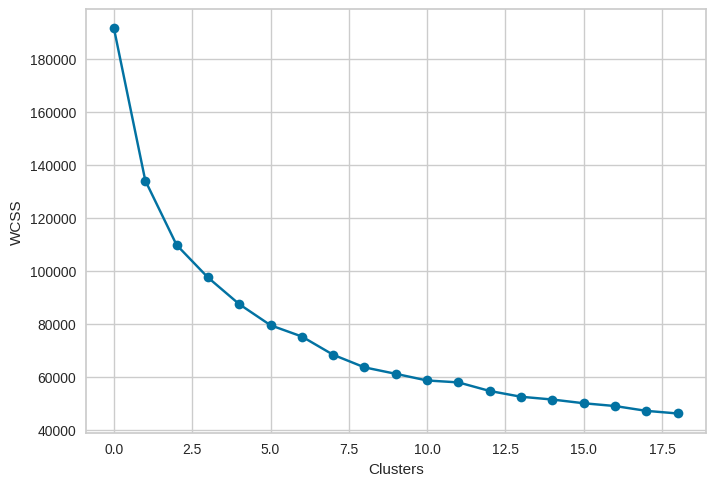

In [61]:
plt.plot(wcss_2, marker='o')
plt.xlabel('Clusters')
plt.ylabel('WCSS');

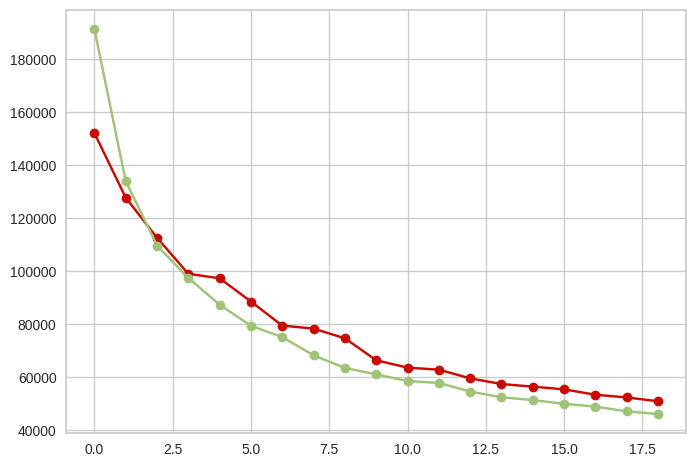

In [62]:
plt.plot(wcss_1, color = 'r', marker='o') # 1º teste
plt.plot(wcss_2, color = 'g', marker='o') # com autoencoder
# quando reduz a dimensionalidade, reduz o número de clusters

In [63]:
# foi decidido fazer com 4 cluster com a base de dados compact = reduziu em 10 colunas das 17 que tinha e tem as predições: a
# codificação dos valores de entradas de 17 colunas em 10 colunas. 10 colunas foi definido na rede neural encoder(do meio)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(compact)

KMeans(n_clusters=4)

In [64]:
labels = kmeans.labels_

In [65]:
#dados originais com os clusters do treinamento com a base de dados do encoder(10colunas)(10neuronios)
#essa é outra técnicna de agrupamento, com menos clusters, pois foi aplicado a redução de dimensionalidade com o AUTOENCODER,
#que foi definido fazer com 4 clusters
df_cluster_at = pd.concat([creditcard_df, pd.DataFrame({'cluster': labels})], axis = 1)
df_cluster_at.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  cluster  
0   201.802084        139.509787          0.000000      12        1  
1  4103.032597       1072.340217          0.222222      12        3  
2   622.066742        627.284787          0.000000      12        1  
3     0.000000        864.206542          0.000000      12        1  
4   678.334763        244.791237          0.000000      12        1

In [66]:
# 1º - foi reduzido os dados (AUTOENCODER)
# 2º - feito agrupamento (KMeans)
# 3º = aplica o PCA para gerar um gráfico, com 2 compoentens
# OU SEJA, como se tivesse reduzido a dimensionalidade em duas vezes
pca = PCA(n_components = 2)
prin_comp = pca.fit_transform(compact)
pca_df = pd.DataFrame(data = prin_comp, columns = ['pca1', 'pca2'])
pca_df.head()

pca1      pca2
0 -1.926577  0.162604
1  0.819049  2.337226
2 -0.465710 -1.013793
3 -1.251043  0.075543
4 -1.975620  0.241927

In [67]:
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster': labels})], axis = 1)
pca_df.head()

pca1      pca2  cluster
0 -1.926577  0.162604        1
1  0.819049  2.337226        3
2 -0.465710 -1.013793        1
3 -1.251043  0.075543        1
4 -1.975620  0.241927        1

<Axes: xlabel='pca1', ylabel='pca2'>

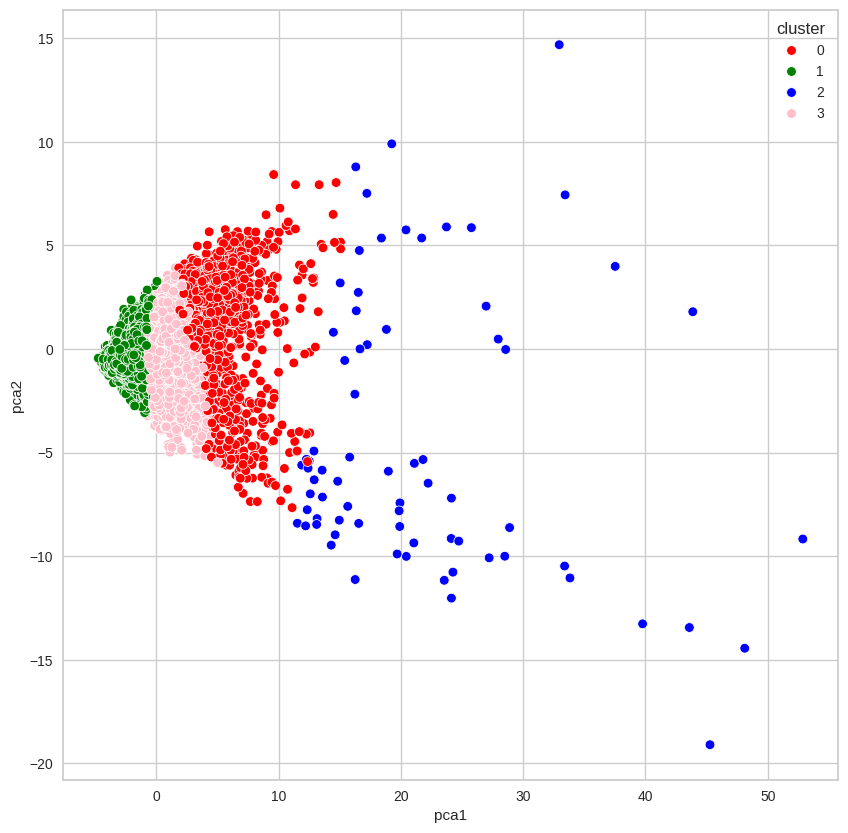

In [68]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = 'pca1', y = 'pca2', hue = 'cluster', data = pca_df, palette = ['red', 'green', 'blue', 'pink'])

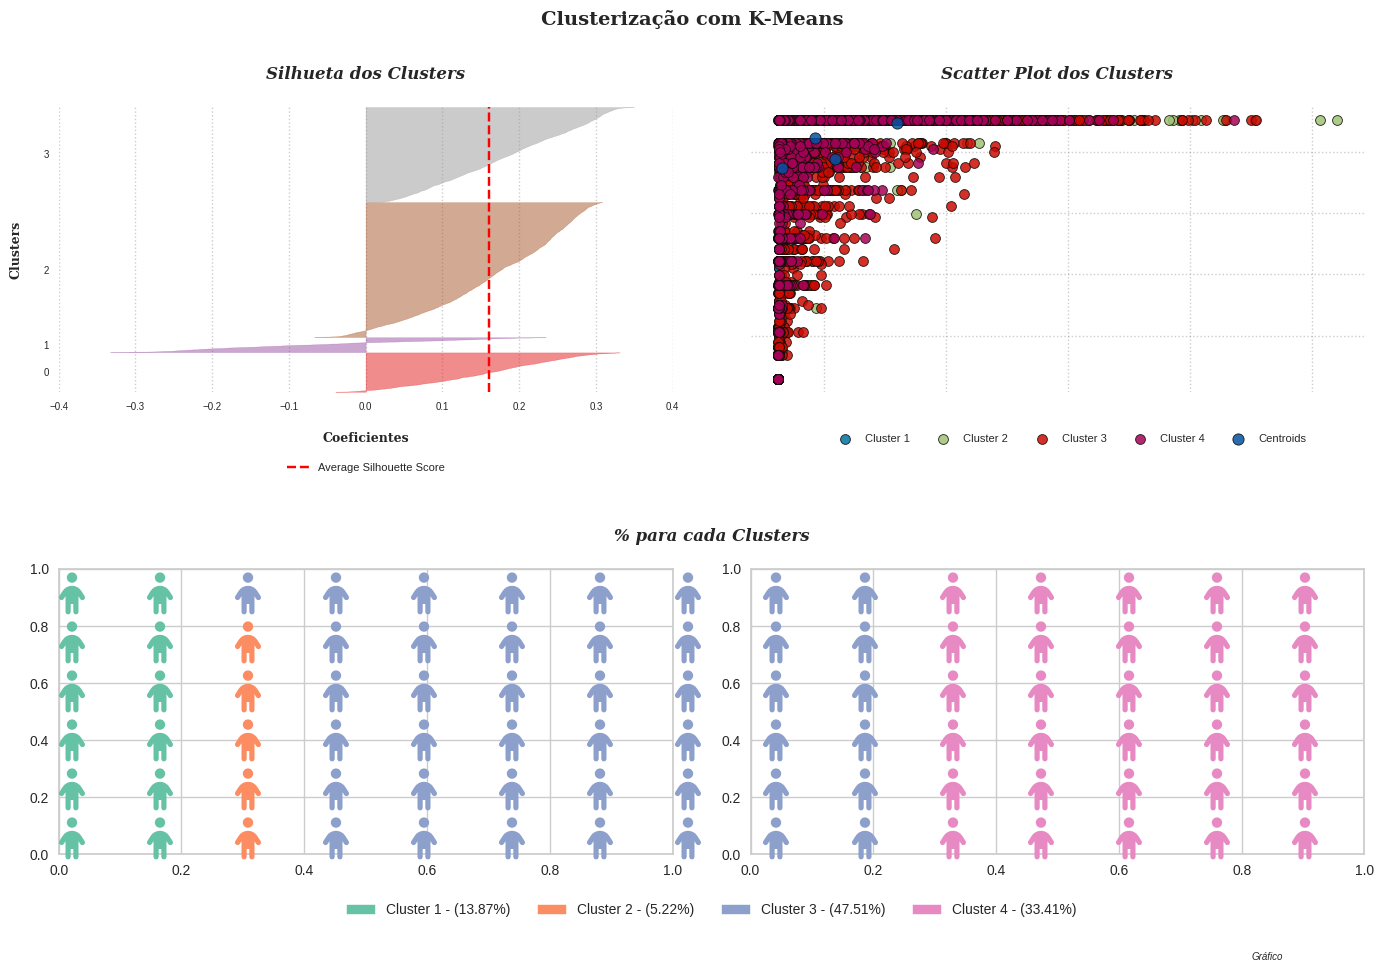

In [69]:
X = pd.DataFrame(creditcard_df_scaled)
X = np.asarray(X)

kmeans = KMeans(n_clusters=n_clusters, random_state=32, max_iter=200)
y_kmeans = kmeans.fit_predict(X)

generate_plots_cluster(kmeans, y_kmeans)

In [70]:
df_cluster_ordered = df_cluster_at.sort_values(by = 'cluster')
df_cluster_ordered.head()

CUST_ID       BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
8949  C19190    372.708075           0.666667    1093.25           1093.25   
7729  C17938   1006.592714           0.909091    1341.62           1341.62   
2593  C12669  11077.991480           1.000000    3419.92           3419.92   
4582  C14708   8033.907466           1.000000     159.00            159.00   
3313  C13407    715.044288           1.000000     249.96              0.00   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
8949                    0.00    127.040008             0.666667   
7729                    0.00      0.000000             0.363636   
2593                    0.00   7837.414142             0.500000   
4582                    0.00   3983.763805             0.083333   
3313                  249.96    828.943053             1.000000   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
8949                    0.666667                          0.000000   
7729                    0.363636                          0.000000   
2593                    0.500000                          0.000000   
4582                    0.083333                          0.000000   
3313                    0.000000                          0.833333   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
8949                0.333333                 2             23        1200.0   
7729                0.000000                 0            186        1200.0   
2593                0.583333                12              8       12000.0   
4582                0.750000                24              1        9000.0   
3313                0.166667                 2              6        1000.0   

          PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  cluster  
8949     63.165404         88.288956               0.0       6        0  
7729   1444.198295        708.609079               0.0      11        0  
2593  10934.502730       7294.953939               0.0      12        0  
4582   1620.868564       2568.327034               0.0      12        0  
3313    189.026970        261.530262               0.0       6        0

## Resultados

In [99]:
creditcard_df['cluster_result'] = y_kmeans# +1
creditcard_df['cluster_result'] = 'Cluster '+creditcard_df['cluster_result'].astype(str)

df_profile_overall = pd.DataFrame()
df_profile_overall['Overall'] = creditcard_df.describe().loc[['mean']].T

df_cluster_summary = creditcard_df.groupby('cluster_result').describe().T.reset_index().rename(columns={'level_0': 'Column Name', 'level_1': 'Metrics'})
df_cluster_summary = df_cluster_summary[df_cluster_summary['Metrics'] == 'mean'].set_index('Column Name')

df_profile = df_cluster_summary.join(df_profile_overall).reset_index()
df_profile

Column Name Metrics    Cluster 0    Cluster 1  \
0                            BALANCE    mean   113.081050  4040.053877   
1                  BALANCE_FREQUENCY    mean     0.812182     0.987502   
2                          PURCHASES    mean  1121.887357  7062.325931   
3                   ONEOFF_PURCHASES    mean   532.138711  4650.722612   
4             INSTALLMENTS_PURCHASES    mean   589.844521  2412.888116   
5                       CASH_ADVANCE    mean    61.384603  1631.906441   
6                PURCHASES_FREQUENCY    mean     0.752545     0.943339   
7         ONEOFF_PURCHASES_FREQUENCY    mean     0.249077     0.710324   
8   PURCHASES_INSTALLMENTS_FREQUENCY    mean     0.576665     0.787797   
9             CASH_ADVANCE_FREQUENCY    mean     0.008976     0.134738   
10                  CASH_ADVANCE_TRX    mean     0.171636     4.438972   
11                     PURCHASES_TRX    mean    17.261080    84.032120   
12                      CREDIT_LIMIT    mean  4643.837936  9818.736617   
13                          PAYMENTS    mean  1373.382990  7605.510573   
14                  MINIMUM_PAYMENTS    mean   169.799505  2201.113350   
15                  PRC_FULL_PAYMENT    mean     0.781267     0.229038   
16                            TENURE    mean    11.420629    11.952891   

      Cluster 2    Cluster 3      Overall  
0   1934.571436  1253.917464  1564.474828  
1      0.846541     0.930769     0.877271  
2    225.086773  1114.129057  1003.204834  
3    183.832476   564.677987   592.437371  
4     41.399417   549.902776   411.067645  
5   1608.508751   362.287173   978.871112  
6      0.127963     0.826117     0.490351  
7      0.076573     0.282803     0.202458  
8      0.051081     0.655844     0.364437  
9      0.222273     0.063670     0.135144  
10     5.361242     1.336120     3.248827  
11     2.279163    20.501003    14.709832  
12  4229.409453  3977.766123  4494.449450  
13  1505.147718  1289.500887  1733.143852  
14   930.207487   849.754247   864.206542  
15     0.031232     0.055663     0.153715  
16    11.384525    11.678261    11.517318

In [100]:
df_profile_freq = df_profile[df_profile['Column Name'] != 'TENURE']
df_profile_frequence = df_profile_freq[df_profile_freq['Column Name'].str.contains('FREQUENCY')]
df_profile_values = df_profile_freq[~(df_profile_freq['Column Name'].str.contains('FREQUENCY'))]

In [101]:
creditcard_df.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE', 'cluster_result'],
      dtype='object')

In [102]:
df_cluster_ordered.head()

CUST_ID       BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
8949  C19190    372.708075           0.666667    1093.25           1093.25   
7729  C17938   1006.592714           0.909091    1341.62           1341.62   
2593  C12669  11077.991480           1.000000    3419.92           3419.92   
4582  C14708   8033.907466           1.000000     159.00            159.00   
3313  C13407    715.044288           1.000000     249.96              0.00   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
8949                    0.00    127.040008             0.666667   
7729                    0.00      0.000000             0.363636   
2593                    0.00   7837.414142             0.500000   
4582                    0.00   3983.763805             0.083333   
3313                  249.96    828.943053             1.000000   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
8949                    0.666667                          0.000000   
7729                    0.363636                          0.000000   
2593                    0.500000                          0.000000   
4582                    0.083333                          0.000000   
3313                    0.000000                          0.833333   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
8949                0.333333                 2             23        1200.0   
7729                0.000000                 0            186        1200.0   
2593                0.583333                12              8       12000.0   
4582                0.750000                24              1        9000.0   
3313                0.166667                 2              6        1000.0   

          PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  cluster  
8949     63.165404         88.288956               0.0       6        0  
7729   1444.198295        708.609079               0.0      11        0  
2593  10934.502730       7294.953939               0.0      12        0  
4582   1620.868564       2568.327034               0.0      12        0  
3313    189.026970        261.530262               0.0       6        0

In [103]:
df_cluster_ordered.to_csv('creditcard_clustered.csv', sep=',')
df_cluster_ordered.to_excel('creditcard_clustered.xlsx')

In [104]:
rename_columns = {
    'CUST_ID': 'ID CUSTO',
    'BALANCE': 'SALDO',
    'BALANCE_FREQUENCY': 'FREQ. SALDO',
    'PURCHASES': 'COMPRAS',
    'ONEOFF_PURCHASES': 'COMPRAS À VISTA',
    'INSTALLMENTS_PURCHASES': 'COMPRAS PARCELADAS',
    'CASH_ADVANCE': 'ADIANTAMENTO CASH',
    'PURCHASES_FREQUENCY': 'FREQ. COMPRAS',
    'ONEOFF_PURCHASES_FREQUENCY': 'FREQ. COMPRAS À VISTA',
    'PURCHASES_INSTALLMENTS_FREQUENCY': 'FREQ. COMPRAS PARCELADAS',
    'CASH_ADVANCE_FREQUENCY': 'FREQ. ADIANTAMENTO CASH',
    'CASH_ADVANCE_TRX': 'TRANSAÇÕES ADIANTAMENTO CASH',
    'PURCHASES_TRX': 'TRANSAÇÕES COMPRAS',
    'CREDIT_LIMIT': 'LIMITE CREDITO',
    'PAYMENTS': 'PAGAMENTOS',
    'MINIMUM_PAYMENTS': 'PAGAMENTOS MINIMOS',
    'PRC_FULL_PAYMENT': '% PAGAMENTO TOTAL',
    'TENURE': 'DURAÇÃO CONTRATO'
}

for name, value in rename_columns.items():
    df_profile.loc[df_profile['Column Name'] == name, 'Column Name'] = value
    df_profile_frequence.loc[df_profile_frequence['Column Name'] == name, 'Column Name'] = value
    df_profile_values.loc[df_profile_values['Column Name'] == name, 'Column Name'] = value

In [105]:
df_profile.to_csv('creditcard_profile.csv', sep=',')
df_profile.to_excel('creditcard_profile.xlsx')

In [106]:
df_profile_frequence.to_csv('creditcard_profile_frequence.csv', sep=',')
df_profile_values.to_csv('creditcard_profile_values.csv', sep=',')

df_profile_frequence.to_excel('creditcard_profile_frequence.xlsx')
df_profile_values.to_excel('creditcard_profile_values.xlsx')

In [107]:
creditcard_df['PURCHASES'].sum()
creditcard_df['BALANCE'].sum()


df_cluster_ordered['PURCHASES'].sum()
df_cluster_ordered['BALANCE'].sum()

14002049.707719

In [110]:
df_profile_values

Column Name Metrics    Cluster 0    Cluster 1  \
0                          SALDO    mean   113.081050  4040.053877   
2                        COMPRAS    mean  1121.887357  7062.325931   
3                COMPRAS À VISTA    mean   532.138711  4650.722612   
4             COMPRAS PARCELADAS    mean   589.844521  2412.888116   
5              ADIANTAMENTO CASH    mean    61.384603  1631.906441   
10  TRANSAÇÕES ADIANTAMENTO CASH    mean     0.171636     4.438972   
11            TRANSAÇÕES COMPRAS    mean    17.261080    84.032120   
12                LIMITE CREDITO    mean  4643.837936  9818.736617   
13                    PAGAMENTOS    mean  1373.382990  7605.510573   
14            PAGAMENTOS MINIMOS    mean   169.799505  2201.113350   
15             % PAGAMENTO TOTAL    mean     0.781267     0.229038   

      Cluster 2    Cluster 3      Overall  
0   1934.571436  1253.917464  1564.474828  
2    225.086773  1114.129057  1003.204834  
3    183.832476   564.677987   592.437371  
4     41.399417   549.902776   411.067645  
5   1608.508751   362.287173   978.871112  
10     5.361242     1.336120     3.248827  
11     2.279163    20.501003    14.709832  
12  4229.409453  3977.766123  4494.449450  
13  1505.147718  1289.500887  1733.143852  
14   930.207487   849.754247   864.206542  
15     0.031232     0.055663     0.153715

In [111]:
df_profile_frequence

Column Name Metrics  Cluster 0  Cluster 1  Cluster 2  \
1               FREQ. SALDO    mean   0.812182   0.987502   0.846541   
6             FREQ. COMPRAS    mean   0.752545   0.943339   0.127963   
7     FREQ. COMPRAS À VISTA    mean   0.249077   0.710324   0.076573   
8  FREQ. COMPRAS PARCELADAS    mean   0.576665   0.787797   0.051081   
9   FREQ. ADIANTAMENTO CASH    mean   0.008976   0.134738   0.222273   

   Cluster 3   Overall  
1   0.930769  0.877271  
6   0.826117  0.490351  
7   0.282803  0.202458  
8   0.655844  0.364437  
9   0.063670  0.135144

In [109]:
(df_cluster_ordered['PAYMENTS'].sum() / df_cluster_ordered['PURCHASES'].sum())

1.7276071586940018

# Conclusão

- Cluster 0: usam o cartão de crédito como empréstimo. Possuem muito dinheiro na conta corrente e sacam muito dinheiro do cartão de crédito, compram pouco e usam bastante o limite do cartão para saques. Pagam muito pouco a fatura completa

- Cluster 1 (clientes novos): clientes mais novos e que mantém pouco dinheiro na conta corrente

- Cluster 2: limite do cartão alto e o mais alto percentual de pagamento da fatura completa. Aumentar o limite do cartão e o hábito de compras

- Cluster 3: Clientes que pagam poucos juros para o banco e são cuidadosos com seu dinheiro. Possui menos dinheiro na conta corrente e não sacam muito dinheiro do limite do cartão.